In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

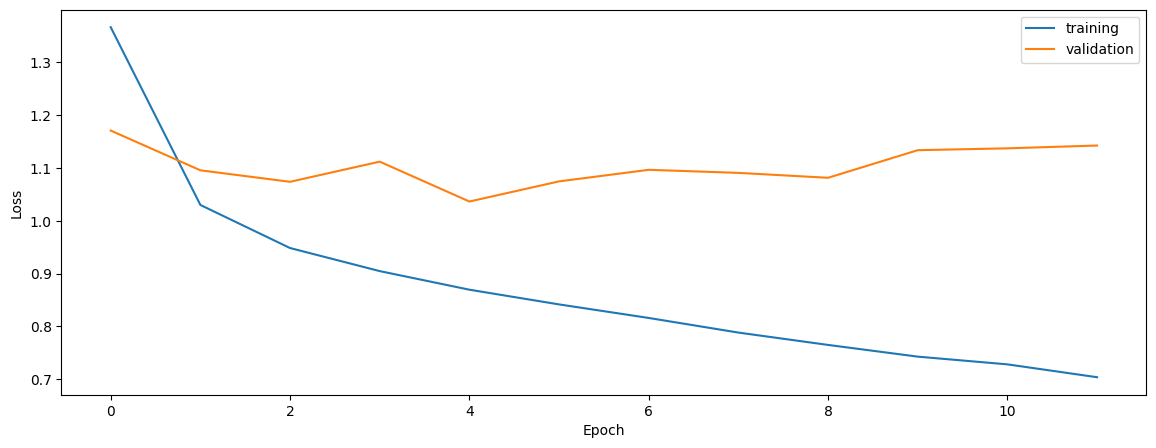

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True
props['collapse_bin'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'BCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_BCE_7_1_0_1_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/107 [..............................] - ETA: 2:07 - loss: 0.7335 - STD: 1.2115e-04 - MAE: 0.5153

  4/107 [>.............................] - ETA: 1s - loss: 0.7000 - STD: 4.8353e-04 - MAE: 0.4655  

  8/107 [=>............................] - ETA: 1s - loss: 0.6870 - STD: 0.0011 - MAE: 0.4718    

 12/107 [==>...........................] - ETA: 1s - loss: 0.6811 - STD: 0.0018 - MAE: 0.4751

 16/107 [===>..........................] - ETA: 1s - loss: 0.6787 - STD: 0.0023 - MAE: 0.4716

 20/107 [====>.........................] - ETA: 1s - loss: 0.6756 - STD: 0.0031 - MAE: 0.4712

 24/107 [=====>........................] - ETA: 1s - loss: 0.6735 - STD: 0.0043 - MAE: 0.4724

 28/107 [======>.......................] - ETA: 1s - loss: 0.6713 - STD: 0.0060 - MAE: 0.4716

 32/107 [=======>......................] - ETA: 1s - loss: 0.6687 - STD: 0.0087 - MAE: 0.4702

 36/107 [=========>....................] - ETA: 1s - loss: 0.6656 - STD: 0.0134 - MAE: 0.4691

 40/107 [==========>...................] - ETA: 1s - loss: 0.6621 - STD: 0.0202 - MAE: 0.4668

 44/107 [===========>..................] - ETA: 1s - loss: 0.6582 - STD: 0.0296 - MAE: 0.4637

 48/107 [============>.................] - ETA: 0s - loss: 0.6543 - STD: 0.0390 - MAE: 0.4604

 52/107 [=============>................] - ETA: 0s - loss: 0.6504 - STD: 0.0475 - MAE: 0.4574

 56/107 [==============>...............] - ETA: 0s - loss: 0.6469 - STD: 0.0558 - MAE: 0.4546

 60/107 [===============>..............] - ETA: 0s - loss: 0.6439 - STD: 0.0634 - MAE: 0.4518

 64/107 [================>.............] - ETA: 0s - loss: 0.6412 - STD: 0.0702 - MAE: 0.4495

 68/107 [==================>...........] - ETA: 0s - loss: 0.6388 - STD: 0.0759 - MAE: 0.4476

 72/107 [===================>..........] - ETA: 0s - loss: 0.6365 - STD: 0.0814 - MAE: 0.4456

 76/107 [====================>.........] - ETA: 0s - loss: 0.6343 - STD: 0.0865 - MAE: 0.4437

 80/107 [=====================>........] - ETA: 0s - loss: 0.6322 - STD: 0.0910 - MAE: 0.4420

 84/107 [======================>.......] - ETA: 0s - loss: 0.6303 - STD: 0.0952 - MAE: 0.4403

 87/107 [=======================>......] - ETA: 0s - loss: 0.6290 - STD: 0.0979 - MAE: 0.4392

 91/107 [========================>.....] - ETA: 0s - loss: 0.6273 - STD: 0.1014 - MAE: 0.4379

 95/107 [=========================>....] - ETA: 0s - loss: 0.6257 - STD: 0.1047 - MAE: 0.4366

 99/107 [==========================>...] - ETA: 0s - loss: 0.6239 - STD: 0.1076 - MAE: 0.4353

103/107 [===========================>..] - ETA: 0s - loss: 0.6223 - STD: 0.1107 - MAE: 0.4339

107/107 [==============================] - ETA: 0s - loss: 0.6206 - STD: 0.1133 - MAE: 0.4327

107/107 [==============================] - 4s 28ms/step - loss: 0.6206 - STD: 0.1133 - MAE: 0.4327 - val_loss: 0.5562 - val_STD: 0.1583 - val_MAE: 0.3879


Epoch 2/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5677 - STD: 0.1894 - MAE: 0.3951

  5/107 [>.............................] - ETA: 1s - loss: 0.5703 - STD: 0.1951 - MAE: 0.3939

  9/107 [=>............................] - ETA: 1s - loss: 0.5720 - STD: 0.1987 - MAE: 0.3898

 13/107 [==>...........................] - ETA: 1s - loss: 0.5731 - STD: 0.2028 - MAE: 0.3877

 17/107 [===>..........................] - ETA: 1s - loss: 0.5703 - STD: 0.2031 - MAE: 0.3871

 21/107 [====>.........................] - ETA: 1s - loss: 0.5688 - STD: 0.2023 - MAE: 0.3872

 25/107 [======>.......................] - ETA: 1s - loss: 0.5675 - STD: 0.2036 - MAE: 0.3863

 29/107 [=======>......................] - ETA: 1s - loss: 0.5658 - STD: 0.2047 - MAE: 0.3850

 33/107 [========>.....................] - ETA: 1s - loss: 0.5649 - STD: 0.2062 - MAE: 0.3843

 37/107 [=========>....................] - ETA: 1s - loss: 0.5641 - STD: 0.2076 - MAE: 0.3835

 41/107 [==========>...................] - ETA: 1s - loss: 0.5632 - STD: 0.2092 - MAE: 0.3826

 45/107 [===========>..................] - ETA: 0s - loss: 0.5622 - STD: 0.2103 - MAE: 0.3816

 49/107 [============>.................] - ETA: 0s - loss: 0.5615 - STD: 0.2108 - MAE: 0.3813

 53/107 [=============>................] - ETA: 0s - loss: 0.5605 - STD: 0.2115 - MAE: 0.3807

 57/107 [==============>...............] - ETA: 0s - loss: 0.5595 - STD: 0.2124 - MAE: 0.3799

 60/107 [===============>..............] - ETA: 0s - loss: 0.5586 - STD: 0.2132 - MAE: 0.3792

 63/107 [================>.............] - ETA: 0s - loss: 0.5579 - STD: 0.2138 - MAE: 0.3787

 67/107 [=================>............] - ETA: 0s - loss: 0.5571 - STD: 0.2148 - MAE: 0.3778

 71/107 [==================>...........] - ETA: 0s - loss: 0.5566 - STD: 0.2158 - MAE: 0.3773

 75/107 [====================>.........] - ETA: 0s - loss: 0.5564 - STD: 0.2163 - MAE: 0.3768

 79/107 [=====================>........] - ETA: 0s - loss: 0.5561 - STD: 0.2166 - MAE: 0.3765

 83/107 [======================>.......] - ETA: 0s - loss: 0.5555 - STD: 0.2169 - MAE: 0.3762

 87/107 [=======================>......] - ETA: 0s - loss: 0.5550 - STD: 0.2171 - MAE: 0.3759

 90/107 [========================>.....] - ETA: 0s - loss: 0.5546 - STD: 0.2174 - MAE: 0.3756

 93/107 [=========================>....] - ETA: 0s - loss: 0.5541 - STD: 0.2178 - MAE: 0.3752

 96/107 [=========================>....] - ETA: 0s - loss: 0.5539 - STD: 0.2183 - MAE: 0.3750

 99/107 [==========================>...] - ETA: 0s - loss: 0.5534 - STD: 0.2187 - MAE: 0.3746

102/107 [===========================>..] - ETA: 0s - loss: 0.5530 - STD: 0.2191 - MAE: 0.3742

105/107 [============================>.] - ETA: 0s - loss: 0.5527 - STD: 0.2195 - MAE: 0.3739

107/107 [==============================] - 2s 19ms/step - loss: 0.5524 - STD: 0.2198 - MAE: 0.3737 - val_loss: 0.5184 - val_STD: 0.2021 - val_MAE: 0.3519


Epoch 3/10000


  1/107 [..............................] - ETA: 5s - loss: 0.5387 - STD: 0.2342 - MAE: 0.3667

  4/107 [>.............................] - ETA: 1s - loss: 0.5386 - STD: 0.2332 - MAE: 0.3634

  7/107 [>.............................] - ETA: 1s - loss: 0.5390 - STD: 0.2320 - MAE: 0.3629

 10/107 [=>............................] - ETA: 1s - loss: 0.5389 - STD: 0.2318 - MAE: 0.3630

 14/107 [==>...........................] - ETA: 1s - loss: 0.5374 - STD: 0.2325 - MAE: 0.3619

 17/107 [===>..........................] - ETA: 1s - loss: 0.5369 - STD: 0.2332 - MAE: 0.3612

 20/107 [====>.........................] - ETA: 1s - loss: 0.5365 - STD: 0.2336 - MAE: 0.3609

 23/107 [=====>........................] - ETA: 1s - loss: 0.5362 - STD: 0.2339 - MAE: 0.3604

 26/107 [======>.......................] - ETA: 1s - loss: 0.5369 - STD: 0.2343 - MAE: 0.3604

 29/107 [=======>......................] - ETA: 1s - loss: 0.5368 - STD: 0.2345 - MAE: 0.3603

 32/107 [=======>......................] - ETA: 1s - loss: 0.5366 - STD: 0.2346 - MAE: 0.3605

 36/107 [=========>....................] - ETA: 1s - loss: 0.5358 - STD: 0.2348 - MAE: 0.3602

 39/107 [=========>....................] - ETA: 1s - loss: 0.5353 - STD: 0.2355 - MAE: 0.3598

 43/107 [===========>..................] - ETA: 1s - loss: 0.5350 - STD: 0.2358 - MAE: 0.3594

 46/107 [===========>..................] - ETA: 1s - loss: 0.5345 - STD: 0.2362 - MAE: 0.3591

 49/107 [============>.................] - ETA: 0s - loss: 0.5342 - STD: 0.2369 - MAE: 0.3587

 52/107 [=============>................] - ETA: 0s - loss: 0.5342 - STD: 0.2372 - MAE: 0.3584

 55/107 [==============>...............] - ETA: 0s - loss: 0.5346 - STD: 0.2370 - MAE: 0.3582

 58/107 [===============>..............] - ETA: 0s - loss: 0.5353 - STD: 0.2368 - MAE: 0.3582

 62/107 [================>.............] - ETA: 0s - loss: 0.5363 - STD: 0.2361 - MAE: 0.3584

 66/107 [=================>............] - ETA: 0s - loss: 0.5361 - STD: 0.2353 - MAE: 0.3587

 70/107 [==================>...........] - ETA: 0s - loss: 0.5361 - STD: 0.2348 - MAE: 0.3590

 73/107 [===================>..........] - ETA: 0s - loss: 0.5357 - STD: 0.2348 - MAE: 0.3591

 76/107 [====================>.........] - ETA: 0s - loss: 0.5357 - STD: 0.2346 - MAE: 0.3590

 79/107 [=====================>........] - ETA: 0s - loss: 0.5354 - STD: 0.2347 - MAE: 0.3587

 82/107 [=====================>........] - ETA: 0s - loss: 0.5353 - STD: 0.2349 - MAE: 0.3585

 85/107 [======================>.......] - ETA: 0s - loss: 0.5350 - STD: 0.2354 - MAE: 0.3583

 89/107 [=======================>......] - ETA: 0s - loss: 0.5348 - STD: 0.2358 - MAE: 0.3580

 92/107 [========================>.....] - ETA: 0s - loss: 0.5346 - STD: 0.2359 - MAE: 0.3579

 95/107 [=========================>....] - ETA: 0s - loss: 0.5344 - STD: 0.2361 - MAE: 0.3578

 98/107 [==========================>...] - ETA: 0s - loss: 0.5342 - STD: 0.2364 - MAE: 0.3577

101/107 [===========================>..] - ETA: 0s - loss: 0.5339 - STD: 0.2366 - MAE: 0.3575

104/107 [============================>.] - ETA: 0s - loss: 0.5337 - STD: 0.2367 - MAE: 0.3573

107/107 [==============================] - 2s 19ms/step - loss: 0.5335 - STD: 0.2368 - MAE: 0.3571 - val_loss: 0.5053 - val_STD: 0.2137 - val_MAE: 0.3455


Epoch 4/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5264 - STD: 0.2478 - MAE: 0.3580

  4/107 [>.............................] - ETA: 1s - loss: 0.5227 - STD: 0.2464 - MAE: 0.3501

  7/107 [>.............................] - ETA: 1s - loss: 0.5247 - STD: 0.2473 - MAE: 0.3495

 11/107 [==>...........................] - ETA: 1s - loss: 0.5244 - STD: 0.2465 - MAE: 0.3497

 14/107 [==>...........................] - ETA: 1s - loss: 0.5241 - STD: 0.2466 - MAE: 0.3497

 17/107 [===>..........................] - ETA: 1s - loss: 0.5238 - STD: 0.2464 - MAE: 0.3493

 20/107 [====>.........................] - ETA: 1s - loss: 0.5236 - STD: 0.2467 - MAE: 0.3493

 23/107 [=====>........................] - ETA: 1s - loss: 0.5231 - STD: 0.2467 - MAE: 0.3492

 26/107 [======>.......................] - ETA: 1s - loss: 0.5225 - STD: 0.2465 - MAE: 0.3490

 29/107 [=======>......................] - ETA: 1s - loss: 0.5220 - STD: 0.2471 - MAE: 0.3488

 32/107 [=======>......................] - ETA: 1s - loss: 0.5221 - STD: 0.2478 - MAE: 0.3486

 35/107 [========>.....................] - ETA: 1s - loss: 0.5218 - STD: 0.2483 - MAE: 0.3482

 39/107 [=========>....................] - ETA: 1s - loss: 0.5223 - STD: 0.2483 - MAE: 0.3478

 43/107 [===========>..................] - ETA: 1s - loss: 0.5221 - STD: 0.2486 - MAE: 0.3474

 46/107 [===========>..................] - ETA: 1s - loss: 0.5229 - STD: 0.2481 - MAE: 0.3474

 49/107 [============>.................] - ETA: 1s - loss: 0.5237 - STD: 0.2476 - MAE: 0.3478

 52/107 [=============>................] - ETA: 0s - loss: 0.5235 - STD: 0.2471 - MAE: 0.3481

 55/107 [==============>...............] - ETA: 0s - loss: 0.5235 - STD: 0.2467 - MAE: 0.3485

 58/107 [===============>..............] - ETA: 0s - loss: 0.5233 - STD: 0.2463 - MAE: 0.3484

 61/107 [================>.............] - ETA: 0s - loss: 0.5231 - STD: 0.2461 - MAE: 0.3483

 65/107 [=================>............] - ETA: 0s - loss: 0.5226 - STD: 0.2463 - MAE: 0.3481

 69/107 [==================>...........] - ETA: 0s - loss: 0.5225 - STD: 0.2467 - MAE: 0.3480

 72/107 [===================>..........] - ETA: 0s - loss: 0.5224 - STD: 0.2468 - MAE: 0.3477

 75/107 [====================>.........] - ETA: 0s - loss: 0.5224 - STD: 0.2470 - MAE: 0.3475

 78/107 [====================>.........] - ETA: 0s - loss: 0.5224 - STD: 0.2472 - MAE: 0.3475

 81/107 [=====================>........] - ETA: 0s - loss: 0.5223 - STD: 0.2473 - MAE: 0.3475

 84/107 [======================>.......] - ETA: 0s - loss: 0.5220 - STD: 0.2475 - MAE: 0.3474

 87/107 [=======================>......] - ETA: 0s - loss: 0.5218 - STD: 0.2476 - MAE: 0.3473

 90/107 [========================>.....] - ETA: 0s - loss: 0.5217 - STD: 0.2476 - MAE: 0.3472

 94/107 [=========================>....] - ETA: 0s - loss: 0.5216 - STD: 0.2477 - MAE: 0.3471

 98/107 [==========================>...] - ETA: 0s - loss: 0.5215 - STD: 0.2480 - MAE: 0.3469

102/107 [===========================>..] - ETA: 0s - loss: 0.5212 - STD: 0.2480 - MAE: 0.3468

106/107 [============================>.] - ETA: 0s - loss: 0.5209 - STD: 0.2482 - MAE: 0.3466

107/107 [==============================] - 2s 19ms/step - loss: 0.5208 - STD: 0.2484 - MAE: 0.3466 - val_loss: 0.4945 - val_STD: 0.2126 - val_MAE: 0.3241


Epoch 5/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5154 - STD: 0.2516 - MAE: 0.3384

  4/107 [>.............................] - ETA: 1s - loss: 0.5128 - STD: 0.2547 - MAE: 0.3404

  8/107 [=>............................] - ETA: 1s - loss: 0.5118 - STD: 0.2553 - MAE: 0.3396

 12/107 [==>...........................] - ETA: 1s - loss: 0.5150 - STD: 0.2564 - MAE: 0.3410

 16/107 [===>..........................] - ETA: 1s - loss: 0.5190 - STD: 0.2533 - MAE: 0.3417

 20/107 [====>.........................] - ETA: 1s - loss: 0.5200 - STD: 0.2521 - MAE: 0.3418

 24/107 [=====>........................] - ETA: 1s - loss: 0.5200 - STD: 0.2502 - MAE: 0.3431

 28/107 [======>.......................] - ETA: 1s - loss: 0.5199 - STD: 0.2493 - MAE: 0.3439

 32/107 [=======>......................] - ETA: 1s - loss: 0.5192 - STD: 0.2491 - MAE: 0.3442

 36/107 [=========>....................] - ETA: 1s - loss: 0.5180 - STD: 0.2493 - MAE: 0.3439

 39/107 [=========>....................] - ETA: 1s - loss: 0.5175 - STD: 0.2500 - MAE: 0.3434

 43/107 [===========>..................] - ETA: 1s - loss: 0.5172 - STD: 0.2509 - MAE: 0.3432

 47/107 [============>.................] - ETA: 0s - loss: 0.5166 - STD: 0.2516 - MAE: 0.3426

 51/107 [=============>................] - ETA: 0s - loss: 0.5160 - STD: 0.2523 - MAE: 0.3420

 55/107 [==============>...............] - ETA: 0s - loss: 0.5158 - STD: 0.2527 - MAE: 0.3418

 59/107 [===============>..............] - ETA: 0s - loss: 0.5155 - STD: 0.2531 - MAE: 0.3416

 63/107 [================>.............] - ETA: 0s - loss: 0.5155 - STD: 0.2531 - MAE: 0.3415

 67/107 [=================>............] - ETA: 0s - loss: 0.5154 - STD: 0.2532 - MAE: 0.3415

 71/107 [==================>...........] - ETA: 0s - loss: 0.5149 - STD: 0.2534 - MAE: 0.3413

 75/107 [====================>.........] - ETA: 0s - loss: 0.5148 - STD: 0.2537 - MAE: 0.3412

 79/107 [=====================>........] - ETA: 0s - loss: 0.5145 - STD: 0.2537 - MAE: 0.3412

 83/107 [======================>.......] - ETA: 0s - loss: 0.5145 - STD: 0.2540 - MAE: 0.3411

 87/107 [=======================>......] - ETA: 0s - loss: 0.5142 - STD: 0.2542 - MAE: 0.3410

 91/107 [========================>.....] - ETA: 0s - loss: 0.5138 - STD: 0.2545 - MAE: 0.3406

 95/107 [=========================>....] - ETA: 0s - loss: 0.5135 - STD: 0.2547 - MAE: 0.3404

 99/107 [==========================>...] - ETA: 0s - loss: 0.5133 - STD: 0.2550 - MAE: 0.3402

103/107 [===========================>..] - ETA: 0s - loss: 0.5131 - STD: 0.2552 - MAE: 0.3400

107/107 [==============================] - ETA: 0s - loss: 0.5132 - STD: 0.2553 - MAE: 0.3399

107/107 [==============================] - 2s 18ms/step - loss: 0.5132 - STD: 0.2553 - MAE: 0.3399 - val_loss: 0.4936 - val_STD: 0.2273 - val_MAE: 0.3339


Epoch 6/10000


  1/107 [..............................] - ETA: 5s - loss: 0.5186 - STD: 0.2628 - MAE: 0.3478

  4/107 [>.............................] - ETA: 2s - loss: 0.5130 - STD: 0.2544 - MAE: 0.3408

  8/107 [=>............................] - ETA: 1s - loss: 0.5138 - STD: 0.2531 - MAE: 0.3394

 12/107 [==>...........................] - ETA: 1s - loss: 0.5137 - STD: 0.2531 - MAE: 0.3400

 16/107 [===>..........................] - ETA: 1s - loss: 0.5140 - STD: 0.2537 - MAE: 0.3410

 20/107 [====>.........................] - ETA: 1s - loss: 0.5147 - STD: 0.2539 - MAE: 0.3401

 24/107 [=====>........................] - ETA: 1s - loss: 0.5147 - STD: 0.2530 - MAE: 0.3401

 28/107 [======>.......................] - ETA: 1s - loss: 0.5143 - STD: 0.2530 - MAE: 0.3400

 32/107 [=======>......................] - ETA: 1s - loss: 0.5142 - STD: 0.2527 - MAE: 0.3406

 36/107 [=========>....................] - ETA: 1s - loss: 0.5141 - STD: 0.2532 - MAE: 0.3405

 40/107 [==========>...................] - ETA: 1s - loss: 0.5133 - STD: 0.2535 - MAE: 0.3400

 44/107 [===========>..................] - ETA: 0s - loss: 0.5132 - STD: 0.2538 - MAE: 0.3398

 48/107 [============>.................] - ETA: 0s - loss: 0.5127 - STD: 0.2543 - MAE: 0.3394

 52/107 [=============>................] - ETA: 0s - loss: 0.5125 - STD: 0.2545 - MAE: 0.3394

 56/107 [==============>...............] - ETA: 0s - loss: 0.5123 - STD: 0.2549 - MAE: 0.3392

 60/107 [===============>..............] - ETA: 0s - loss: 0.5120 - STD: 0.2552 - MAE: 0.3389

 64/107 [================>.............] - ETA: 0s - loss: 0.5117 - STD: 0.2553 - MAE: 0.3387

 68/107 [==================>...........] - ETA: 0s - loss: 0.5114 - STD: 0.2558 - MAE: 0.3385

 72/107 [===================>..........] - ETA: 0s - loss: 0.5109 - STD: 0.2559 - MAE: 0.3383

 76/107 [====================>.........] - ETA: 0s - loss: 0.5105 - STD: 0.2563 - MAE: 0.3380

 80/107 [=====================>........] - ETA: 0s - loss: 0.5101 - STD: 0.2566 - MAE: 0.3378

 84/107 [======================>.......] - ETA: 0s - loss: 0.5096 - STD: 0.2571 - MAE: 0.3374

 88/107 [=======================>......] - ETA: 0s - loss: 0.5094 - STD: 0.2574 - MAE: 0.3370

 92/107 [========================>.....] - ETA: 0s - loss: 0.5091 - STD: 0.2579 - MAE: 0.3367

 96/107 [=========================>....] - ETA: 0s - loss: 0.5091 - STD: 0.2581 - MAE: 0.3366

100/107 [===========================>..] - ETA: 0s - loss: 0.5097 - STD: 0.2580 - MAE: 0.3366

104/107 [============================>.] - ETA: 0s - loss: 0.5109 - STD: 0.2573 - MAE: 0.3369

107/107 [==============================] - 2s 17ms/step - loss: 0.5112 - STD: 0.2570 - MAE: 0.3373 - val_loss: 0.5054 - val_STD: 0.1856 - val_MAE: 0.3298


Epoch 7/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5265 - STD: 0.2227 - MAE: 0.3457

  4/107 [>.............................] - ETA: 1s - loss: 0.5224 - STD: 0.2334 - MAE: 0.3540

  8/107 [=>............................] - ETA: 1s - loss: 0.5213 - STD: 0.2362 - MAE: 0.3527

 12/107 [==>...........................] - ETA: 1s - loss: 0.5180 - STD: 0.2394 - MAE: 0.3499

 16/107 [===>..........................] - ETA: 1s - loss: 0.5153 - STD: 0.2426 - MAE: 0.3473

 20/107 [====>.........................] - ETA: 1s - loss: 0.5131 - STD: 0.2459 - MAE: 0.3447

 24/107 [=====>........................] - ETA: 1s - loss: 0.5118 - STD: 0.2488 - MAE: 0.3425

 28/107 [======>.......................] - ETA: 1s - loss: 0.5108 - STD: 0.2510 - MAE: 0.3409

 32/107 [=======>......................] - ETA: 1s - loss: 0.5098 - STD: 0.2527 - MAE: 0.3397

 36/107 [=========>....................] - ETA: 1s - loss: 0.5092 - STD: 0.2541 - MAE: 0.3389

 40/107 [==========>...................] - ETA: 1s - loss: 0.5086 - STD: 0.2549 - MAE: 0.3384

 44/107 [===========>..................] - ETA: 0s - loss: 0.5080 - STD: 0.2557 - MAE: 0.3377

 48/107 [============>.................] - ETA: 0s - loss: 0.5071 - STD: 0.2562 - MAE: 0.3370

 52/107 [=============>................] - ETA: 0s - loss: 0.5065 - STD: 0.2570 - MAE: 0.3364

 56/107 [==============>...............] - ETA: 0s - loss: 0.5063 - STD: 0.2575 - MAE: 0.3362

 60/107 [===============>..............] - ETA: 0s - loss: 0.5059 - STD: 0.2583 - MAE: 0.3357

 64/107 [================>.............] - ETA: 0s - loss: 0.5055 - STD: 0.2588 - MAE: 0.3353

 68/107 [==================>...........] - ETA: 0s - loss: 0.5052 - STD: 0.2594 - MAE: 0.3349

 72/107 [===================>..........] - ETA: 0s - loss: 0.5051 - STD: 0.2598 - MAE: 0.3348

 76/107 [====================>.........] - ETA: 0s - loss: 0.5058 - STD: 0.2598 - MAE: 0.3346

 80/107 [=====================>........] - ETA: 0s - loss: 0.5068 - STD: 0.2594 - MAE: 0.3347

 84/107 [======================>.......] - ETA: 0s - loss: 0.5070 - STD: 0.2591 - MAE: 0.3349

 88/107 [=======================>......] - ETA: 0s - loss: 0.5071 - STD: 0.2586 - MAE: 0.3353

 92/107 [========================>.....] - ETA: 0s - loss: 0.5071 - STD: 0.2584 - MAE: 0.3355

 96/107 [=========================>....] - ETA: 0s - loss: 0.5070 - STD: 0.2583 - MAE: 0.3356

100/107 [===========================>..] - ETA: 0s - loss: 0.5070 - STD: 0.2584 - MAE: 0.3356

104/107 [============================>.] - ETA: 0s - loss: 0.5070 - STD: 0.2586 - MAE: 0.3355

107/107 [==============================] - 2s 17ms/step - loss: 0.5069 - STD: 0.2587 - MAE: 0.3354 - val_loss: 0.4824 - val_STD: 0.2189 - val_MAE: 0.3176


Epoch 8/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4925 - STD: 0.2566 - MAE: 0.3281

  4/107 [>.............................] - ETA: 1s - loss: 0.4969 - STD: 0.2618 - MAE: 0.3304

  8/107 [=>............................] - ETA: 1s - loss: 0.5013 - STD: 0.2626 - MAE: 0.3302

 12/107 [==>...........................] - ETA: 1s - loss: 0.5013 - STD: 0.2630 - MAE: 0.3299

 16/107 [===>..........................] - ETA: 1s - loss: 0.5010 - STD: 0.2635 - MAE: 0.3302

 20/107 [====>.........................] - ETA: 1s - loss: 0.5009 - STD: 0.2643 - MAE: 0.3303

 24/107 [=====>........................] - ETA: 1s - loss: 0.4999 - STD: 0.2648 - MAE: 0.3298

 28/107 [======>.......................] - ETA: 1s - loss: 0.4996 - STD: 0.2654 - MAE: 0.3297

 32/107 [=======>......................] - ETA: 1s - loss: 0.5003 - STD: 0.2652 - MAE: 0.3296

 36/107 [=========>....................] - ETA: 1s - loss: 0.5017 - STD: 0.2650 - MAE: 0.3298

 40/107 [==========>...................] - ETA: 1s - loss: 0.5013 - STD: 0.2649 - MAE: 0.3299

 44/107 [===========>..................] - ETA: 0s - loss: 0.5015 - STD: 0.2645 - MAE: 0.3302

 48/107 [============>.................] - ETA: 0s - loss: 0.5017 - STD: 0.2644 - MAE: 0.3305

 52/107 [=============>................] - ETA: 0s - loss: 0.5018 - STD: 0.2642 - MAE: 0.3305

 56/107 [==============>...............] - ETA: 0s - loss: 0.5016 - STD: 0.2641 - MAE: 0.3305

 60/107 [===============>..............] - ETA: 0s - loss: 0.5013 - STD: 0.2641 - MAE: 0.3305

 64/107 [================>.............] - ETA: 0s - loss: 0.5013 - STD: 0.2642 - MAE: 0.3305

 68/107 [==================>...........] - ETA: 0s - loss: 0.5009 - STD: 0.2645 - MAE: 0.3302

 72/107 [===================>..........] - ETA: 0s - loss: 0.5007 - STD: 0.2647 - MAE: 0.3300

 76/107 [====================>.........] - ETA: 0s - loss: 0.5007 - STD: 0.2651 - MAE: 0.3299

 80/107 [=====================>........] - ETA: 0s - loss: 0.5006 - STD: 0.2651 - MAE: 0.3298

 84/107 [======================>.......] - ETA: 0s - loss: 0.5006 - STD: 0.2653 - MAE: 0.3296

 88/107 [=======================>......] - ETA: 0s - loss: 0.5004 - STD: 0.2653 - MAE: 0.3296

 92/107 [========================>.....] - ETA: 0s - loss: 0.5004 - STD: 0.2656 - MAE: 0.3295

 96/107 [=========================>....] - ETA: 0s - loss: 0.5003 - STD: 0.2655 - MAE: 0.3295

100/107 [===========================>..] - ETA: 0s - loss: 0.5007 - STD: 0.2656 - MAE: 0.3296

104/107 [============================>.] - ETA: 0s - loss: 0.5009 - STD: 0.2655 - MAE: 0.3296

107/107 [==============================] - 2s 17ms/step - loss: 0.5013 - STD: 0.2654 - MAE: 0.3297 - val_loss: 0.4913 - val_STD: 0.2060 - val_MAE: 0.3141


Epoch 9/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5061 - STD: 0.2499 - MAE: 0.3273

  5/107 [>.............................] - ETA: 1s - loss: 0.5079 - STD: 0.2575 - MAE: 0.3338

  9/107 [=>............................] - ETA: 1s - loss: 0.5074 - STD: 0.2558 - MAE: 0.3353

 13/107 [==>...........................] - ETA: 1s - loss: 0.5089 - STD: 0.2553 - MAE: 0.3359

 17/107 [===>..........................] - ETA: 1s - loss: 0.5088 - STD: 0.2550 - MAE: 0.3367

 21/107 [====>.........................] - ETA: 1s - loss: 0.5077 - STD: 0.2557 - MAE: 0.3363

 25/107 [======>.......................] - ETA: 1s - loss: 0.5061 - STD: 0.2570 - MAE: 0.3353

 29/107 [=======>......................] - ETA: 1s - loss: 0.5052 - STD: 0.2583 - MAE: 0.3343

 33/107 [========>.....................] - ETA: 1s - loss: 0.5040 - STD: 0.2592 - MAE: 0.3333

 37/107 [=========>....................] - ETA: 1s - loss: 0.5033 - STD: 0.2602 - MAE: 0.3325

 41/107 [==========>...................] - ETA: 1s - loss: 0.5027 - STD: 0.2610 - MAE: 0.3319

 45/107 [===========>..................] - ETA: 0s - loss: 0.5020 - STD: 0.2619 - MAE: 0.3313

 49/107 [============>.................] - ETA: 0s - loss: 0.5019 - STD: 0.2624 - MAE: 0.3312

 53/107 [=============>................] - ETA: 0s - loss: 0.5016 - STD: 0.2628 - MAE: 0.3308

 57/107 [==============>...............] - ETA: 0s - loss: 0.5012 - STD: 0.2631 - MAE: 0.3306

 60/107 [===============>..............] - ETA: 0s - loss: 0.5010 - STD: 0.2634 - MAE: 0.3304

 64/107 [================>.............] - ETA: 0s - loss: 0.5003 - STD: 0.2637 - MAE: 0.3301

 68/107 [==================>...........] - ETA: 0s - loss: 0.4997 - STD: 0.2642 - MAE: 0.3296

 72/107 [===================>..........] - ETA: 0s - loss: 0.4995 - STD: 0.2646 - MAE: 0.3294

 75/107 [====================>.........] - ETA: 0s - loss: 0.4991 - STD: 0.2650 - MAE: 0.3291

 79/107 [=====================>........] - ETA: 0s - loss: 0.4989 - STD: 0.2654 - MAE: 0.3288

 82/107 [=====================>........] - ETA: 0s - loss: 0.4987 - STD: 0.2657 - MAE: 0.3286

 86/107 [=======================>......] - ETA: 0s - loss: 0.4986 - STD: 0.2660 - MAE: 0.3285

 90/107 [========================>.....] - ETA: 0s - loss: 0.4987 - STD: 0.2660 - MAE: 0.3284

 94/107 [=========================>....] - ETA: 0s - loss: 0.4985 - STD: 0.2661 - MAE: 0.3283

 98/107 [==========================>...] - ETA: 0s - loss: 0.4985 - STD: 0.2662 - MAE: 0.3283

101/107 [===========================>..] - ETA: 0s - loss: 0.4985 - STD: 0.2662 - MAE: 0.3283

104/107 [============================>.] - ETA: 0s - loss: 0.4985 - STD: 0.2663 - MAE: 0.3283

107/107 [==============================] - 2s 19ms/step - loss: 0.4983 - STD: 0.2663 - MAE: 0.3282 - val_loss: 0.4817 - val_STD: 0.2359 - val_MAE: 0.3224


Epoch 10/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5011 - STD: 0.2748 - MAE: 0.3342

  4/107 [>.............................] - ETA: 1s - loss: 0.4982 - STD: 0.2717 - MAE: 0.3275

  7/107 [>.............................] - ETA: 1s - loss: 0.4942 - STD: 0.2709 - MAE: 0.3258

 10/107 [=>............................] - ETA: 1s - loss: 0.4937 - STD: 0.2711 - MAE: 0.3252

 13/107 [==>...........................] - ETA: 1s - loss: 0.4950 - STD: 0.2712 - MAE: 0.3257

 16/107 [===>..........................] - ETA: 1s - loss: 0.4949 - STD: 0.2709 - MAE: 0.3254

 19/107 [====>.........................] - ETA: 1s - loss: 0.4959 - STD: 0.2707 - MAE: 0.3252

 22/107 [=====>........................] - ETA: 1s - loss: 0.4979 - STD: 0.2697 - MAE: 0.3262

 26/107 [======>.......................] - ETA: 1s - loss: 0.4996 - STD: 0.2686 - MAE: 0.3262

 29/107 [=======>......................] - ETA: 1s - loss: 0.5004 - STD: 0.2674 - MAE: 0.3273

 32/107 [=======>......................] - ETA: 1s - loss: 0.5004 - STD: 0.2668 - MAE: 0.3277

 35/107 [========>.....................] - ETA: 1s - loss: 0.5002 - STD: 0.2660 - MAE: 0.3279

 38/107 [=========>....................] - ETA: 1s - loss: 0.5001 - STD: 0.2655 - MAE: 0.3282

 41/107 [==========>...................] - ETA: 1s - loss: 0.4998 - STD: 0.2656 - MAE: 0.3281

 44/107 [===========>..................] - ETA: 1s - loss: 0.4992 - STD: 0.2658 - MAE: 0.3280

 47/107 [============>.................] - ETA: 1s - loss: 0.4989 - STD: 0.2662 - MAE: 0.3278

 50/107 [=============>................] - ETA: 1s - loss: 0.4986 - STD: 0.2666 - MAE: 0.3276

 53/107 [=============>................] - ETA: 0s - loss: 0.4985 - STD: 0.2669 - MAE: 0.3275

 57/107 [==============>...............] - ETA: 0s - loss: 0.4983 - STD: 0.2671 - MAE: 0.3272

 60/107 [===============>..............] - ETA: 0s - loss: 0.4986 - STD: 0.2671 - MAE: 0.3273

 63/107 [================>.............] - ETA: 0s - loss: 0.4987 - STD: 0.2672 - MAE: 0.3273

 66/107 [=================>............] - ETA: 0s - loss: 0.4985 - STD: 0.2672 - MAE: 0.3274

 69/107 [==================>...........] - ETA: 0s - loss: 0.4984 - STD: 0.2670 - MAE: 0.3274

 72/107 [===================>..........] - ETA: 0s - loss: 0.4979 - STD: 0.2670 - MAE: 0.3272

 76/107 [====================>.........] - ETA: 0s - loss: 0.4975 - STD: 0.2672 - MAE: 0.3270

 80/107 [=====================>........] - ETA: 0s - loss: 0.4970 - STD: 0.2675 - MAE: 0.3266

 84/107 [======================>.......] - ETA: 0s - loss: 0.4967 - STD: 0.2679 - MAE: 0.3263

 87/107 [=======================>......] - ETA: 0s - loss: 0.4967 - STD: 0.2682 - MAE: 0.3262

 90/107 [========================>.....] - ETA: 0s - loss: 0.4966 - STD: 0.2683 - MAE: 0.3260

 93/107 [=========================>....] - ETA: 0s - loss: 0.4965 - STD: 0.2684 - MAE: 0.3260

 96/107 [=========================>....] - ETA: 0s - loss: 0.4965 - STD: 0.2684 - MAE: 0.3260

 99/107 [==========================>...] - ETA: 0s - loss: 0.4962 - STD: 0.2685 - MAE: 0.3259

102/107 [===========================>..] - ETA: 0s - loss: 0.4960 - STD: 0.2686 - MAE: 0.3258

106/107 [============================>.] - ETA: 0s - loss: 0.4958 - STD: 0.2687 - MAE: 0.3257

107/107 [==============================] - 2s 20ms/step - loss: 0.4959 - STD: 0.2688 - MAE: 0.3258 - val_loss: 0.4950 - val_STD: 0.2090 - val_MAE: 0.3056


Epoch 11/10000


  1/107 [..............................] - ETA: 5s - loss: 0.5103 - STD: 0.2553 - MAE: 0.3188

  4/107 [>.............................] - ETA: 1s - loss: 0.5082 - STD: 0.2620 - MAE: 0.3232

  7/107 [>.............................] - ETA: 1s - loss: 0.5272 - STD: 0.2591 - MAE: 0.3290

 10/107 [=>............................] - ETA: 1s - loss: 0.5415 - STD: 0.2566 - MAE: 0.3356

 13/107 [==>...........................] - ETA: 1s - loss: 0.5454 - STD: 0.2442 - MAE: 0.3383

 16/107 [===>..........................] - ETA: 1s - loss: 0.5436 - STD: 0.2403 - MAE: 0.3453

 19/107 [====>.........................] - ETA: 1s - loss: 0.5438 - STD: 0.2340 - MAE: 0.3480

 22/107 [=====>........................] - ETA: 1s - loss: 0.5420 - STD: 0.2323 - MAE: 0.3516

 25/107 [======>.......................] - ETA: 1s - loss: 0.5395 - STD: 0.2294 - MAE: 0.3527

 28/107 [======>.......................] - ETA: 1s - loss: 0.5361 - STD: 0.2307 - MAE: 0.3528

 31/107 [=======>......................] - ETA: 1s - loss: 0.5334 - STD: 0.2333 - MAE: 0.3507

 34/107 [========>.....................] - ETA: 1s - loss: 0.5311 - STD: 0.2367 - MAE: 0.3492

 37/107 [=========>....................] - ETA: 1s - loss: 0.5289 - STD: 0.2389 - MAE: 0.3476

 40/107 [==========>...................] - ETA: 1s - loss: 0.5267 - STD: 0.2416 - MAE: 0.3455

 43/107 [===========>..................] - ETA: 1s - loss: 0.5249 - STD: 0.2438 - MAE: 0.3443

 46/107 [===========>..................] - ETA: 1s - loss: 0.5228 - STD: 0.2451 - MAE: 0.3433

 49/107 [============>.................] - ETA: 1s - loss: 0.5210 - STD: 0.2464 - MAE: 0.3419

 52/107 [=============>................] - ETA: 0s - loss: 0.5194 - STD: 0.2477 - MAE: 0.3410

 55/107 [==============>...............] - ETA: 0s - loss: 0.5180 - STD: 0.2488 - MAE: 0.3403

 58/107 [===============>..............] - ETA: 0s - loss: 0.5166 - STD: 0.2497 - MAE: 0.3394

 61/107 [================>.............] - ETA: 0s - loss: 0.5157 - STD: 0.2505 - MAE: 0.3388

 64/107 [================>.............] - ETA: 0s - loss: 0.5149 - STD: 0.2516 - MAE: 0.3383

 67/107 [=================>............] - ETA: 0s - loss: 0.5139 - STD: 0.2525 - MAE: 0.3377

 70/107 [==================>...........] - ETA: 0s - loss: 0.5128 - STD: 0.2533 - MAE: 0.3370

 73/107 [===================>..........] - ETA: 0s - loss: 0.5118 - STD: 0.2541 - MAE: 0.3364

 76/107 [====================>.........] - ETA: 0s - loss: 0.5108 - STD: 0.2549 - MAE: 0.3358

 79/107 [=====================>........] - ETA: 0s - loss: 0.5099 - STD: 0.2557 - MAE: 0.3352

 83/107 [======================>.......] - ETA: 0s - loss: 0.5087 - STD: 0.2567 - MAE: 0.3344

 86/107 [=======================>......] - ETA: 0s - loss: 0.5081 - STD: 0.2574 - MAE: 0.3339

 89/107 [=======================>......] - ETA: 0s - loss: 0.5075 - STD: 0.2580 - MAE: 0.3335

 92/107 [========================>.....] - ETA: 0s - loss: 0.5068 - STD: 0.2587 - MAE: 0.3330

 95/107 [=========================>....] - ETA: 0s - loss: 0.5062 - STD: 0.2593 - MAE: 0.3326

 98/107 [==========================>...] - ETA: 0s - loss: 0.5056 - STD: 0.2598 - MAE: 0.3322

101/107 [===========================>..] - ETA: 0s - loss: 0.5052 - STD: 0.2602 - MAE: 0.3319

104/107 [============================>.] - ETA: 0s - loss: 0.5047 - STD: 0.2607 - MAE: 0.3315

107/107 [==============================] - ETA: 0s - loss: 0.5044 - STD: 0.2610 - MAE: 0.3313

107/107 [==============================] - 2s 20ms/step - loss: 0.5044 - STD: 0.2610 - MAE: 0.3313 - val_loss: 0.4747 - val_STD: 0.2304 - val_MAE: 0.3099


Epoch 12/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4906 - STD: 0.2698 - MAE: 0.3221

  3/107 [..............................] - ETA: 2s - loss: 0.4912 - STD: 0.2743 - MAE: 0.3222

  6/107 [>.............................] - ETA: 2s - loss: 0.4903 - STD: 0.2730 - MAE: 0.3216

  9/107 [=>............................] - ETA: 1s - loss: 0.4892 - STD: 0.2723 - MAE: 0.3213

 13/107 [==>...........................] - ETA: 1s - loss: 0.4889 - STD: 0.2731 - MAE: 0.3211

 16/107 [===>..........................] - ETA: 1s - loss: 0.4886 - STD: 0.2732 - MAE: 0.3210

 19/107 [====>.........................] - ETA: 1s - loss: 0.4894 - STD: 0.2734 - MAE: 0.3213

 22/107 [=====>........................] - ETA: 1s - loss: 0.4890 - STD: 0.2738 - MAE: 0.3212

 25/107 [======>.......................] - ETA: 1s - loss: 0.4894 - STD: 0.2738 - MAE: 0.3213

 28/107 [======>.......................] - ETA: 1s - loss: 0.4903 - STD: 0.2738 - MAE: 0.3217

 31/107 [=======>......................] - ETA: 1s - loss: 0.4899 - STD: 0.2738 - MAE: 0.3215

 34/107 [========>.....................] - ETA: 1s - loss: 0.4890 - STD: 0.2737 - MAE: 0.3212

 37/107 [=========>....................] - ETA: 1s - loss: 0.4891 - STD: 0.2739 - MAE: 0.3212

 41/107 [==========>...................] - ETA: 1s - loss: 0.4886 - STD: 0.2740 - MAE: 0.3208

 44/107 [===========>..................] - ETA: 1s - loss: 0.4884 - STD: 0.2742 - MAE: 0.3205

 47/107 [============>.................] - ETA: 1s - loss: 0.4882 - STD: 0.2745 - MAE: 0.3204

 50/107 [=============>................] - ETA: 1s - loss: 0.4882 - STD: 0.2748 - MAE: 0.3202

 53/107 [=============>................] - ETA: 0s - loss: 0.4879 - STD: 0.2747 - MAE: 0.3199

 56/107 [==============>...............] - ETA: 0s - loss: 0.4883 - STD: 0.2747 - MAE: 0.3200

 59/107 [===============>..............] - ETA: 0s - loss: 0.4886 - STD: 0.2746 - MAE: 0.3200

 62/107 [================>.............] - ETA: 0s - loss: 0.4890 - STD: 0.2744 - MAE: 0.3202

 66/107 [=================>............] - ETA: 0s - loss: 0.4896 - STD: 0.2743 - MAE: 0.3206

 70/107 [==================>...........] - ETA: 0s - loss: 0.4895 - STD: 0.2741 - MAE: 0.3208

 73/107 [===================>..........] - ETA: 0s - loss: 0.4895 - STD: 0.2738 - MAE: 0.3209

 76/107 [====================>.........] - ETA: 0s - loss: 0.4895 - STD: 0.2737 - MAE: 0.3210

 79/107 [=====================>........] - ETA: 0s - loss: 0.4894 - STD: 0.2737 - MAE: 0.3210

 82/107 [=====================>........] - ETA: 0s - loss: 0.4893 - STD: 0.2737 - MAE: 0.3210

 85/107 [======================>.......] - ETA: 0s - loss: 0.4894 - STD: 0.2738 - MAE: 0.3210

 89/107 [=======================>......] - ETA: 0s - loss: 0.4892 - STD: 0.2740 - MAE: 0.3209

 93/107 [=========================>....] - ETA: 0s - loss: 0.4893 - STD: 0.2742 - MAE: 0.3209

 96/107 [=========================>....] - ETA: 0s - loss: 0.4894 - STD: 0.2742 - MAE: 0.3208

 99/107 [==========================>...] - ETA: 0s - loss: 0.4895 - STD: 0.2742 - MAE: 0.3208

102/107 [===========================>..] - ETA: 0s - loss: 0.4901 - STD: 0.2740 - MAE: 0.3209

105/107 [============================>.] - ETA: 0s - loss: 0.4904 - STD: 0.2738 - MAE: 0.3210

107/107 [==============================] - 2s 20ms/step - loss: 0.4903 - STD: 0.2736 - MAE: 0.3210 - val_loss: 0.4747 - val_STD: 0.2248 - val_MAE: 0.3148


Epoch 13/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4838 - STD: 0.2687 - MAE: 0.3238

  4/107 [>.............................] - ETA: 1s - loss: 0.4899 - STD: 0.2655 - MAE: 0.3253

  7/107 [>.............................] - ETA: 1s - loss: 0.4897 - STD: 0.2653 - MAE: 0.3263

 10/107 [=>............................] - ETA: 1s - loss: 0.4889 - STD: 0.2668 - MAE: 0.3254

 14/107 [==>...........................] - ETA: 1s - loss: 0.4894 - STD: 0.2675 - MAE: 0.3244

 17/107 [===>..........................] - ETA: 1s - loss: 0.4900 - STD: 0.2688 - MAE: 0.3243

 20/107 [====>.........................] - ETA: 1s - loss: 0.4899 - STD: 0.2700 - MAE: 0.3238

 23/107 [=====>........................] - ETA: 1s - loss: 0.4894 - STD: 0.2706 - MAE: 0.3231

 26/107 [======>.......................] - ETA: 1s - loss: 0.4886 - STD: 0.2710 - MAE: 0.3224

 29/107 [=======>......................] - ETA: 1s - loss: 0.4882 - STD: 0.2719 - MAE: 0.3217

 32/107 [=======>......................] - ETA: 1s - loss: 0.4882 - STD: 0.2720 - MAE: 0.3216

 35/107 [========>.....................] - ETA: 1s - loss: 0.4876 - STD: 0.2727 - MAE: 0.3212

 38/107 [=========>....................] - ETA: 1s - loss: 0.4877 - STD: 0.2731 - MAE: 0.3210

 41/107 [==========>...................] - ETA: 1s - loss: 0.4877 - STD: 0.2735 - MAE: 0.3209

 44/107 [===========>..................] - ETA: 1s - loss: 0.4872 - STD: 0.2740 - MAE: 0.3205

 47/107 [============>.................] - ETA: 1s - loss: 0.4868 - STD: 0.2743 - MAE: 0.3202

 50/107 [=============>................] - ETA: 1s - loss: 0.4869 - STD: 0.2745 - MAE: 0.3201

 53/107 [=============>................] - ETA: 0s - loss: 0.4869 - STD: 0.2746 - MAE: 0.3200

 56/107 [==============>...............] - ETA: 0s - loss: 0.4870 - STD: 0.2746 - MAE: 0.3198

 59/107 [===============>..............] - ETA: 0s - loss: 0.4870 - STD: 0.2745 - MAE: 0.3198

 62/107 [================>.............] - ETA: 0s - loss: 0.4866 - STD: 0.2745 - MAE: 0.3196

 65/107 [=================>............] - ETA: 0s - loss: 0.4868 - STD: 0.2744 - MAE: 0.3197

 68/107 [==================>...........] - ETA: 0s - loss: 0.4869 - STD: 0.2746 - MAE: 0.3197

 71/107 [==================>...........] - ETA: 0s - loss: 0.4869 - STD: 0.2746 - MAE: 0.3198

 74/107 [===================>..........] - ETA: 0s - loss: 0.4870 - STD: 0.2747 - MAE: 0.3198

 77/107 [====================>.........] - ETA: 0s - loss: 0.4871 - STD: 0.2748 - MAE: 0.3197

 80/107 [=====================>........] - ETA: 0s - loss: 0.4870 - STD: 0.2748 - MAE: 0.3197

 83/107 [======================>.......] - ETA: 0s - loss: 0.4869 - STD: 0.2749 - MAE: 0.3196

 87/107 [=======================>......] - ETA: 0s - loss: 0.4866 - STD: 0.2750 - MAE: 0.3195

 90/107 [========================>.....] - ETA: 0s - loss: 0.4865 - STD: 0.2751 - MAE: 0.3194

 93/107 [=========================>....] - ETA: 0s - loss: 0.4867 - STD: 0.2752 - MAE: 0.3193

 96/107 [=========================>....] - ETA: 0s - loss: 0.4870 - STD: 0.2751 - MAE: 0.3193

 99/107 [==========================>...] - ETA: 0s - loss: 0.4875 - STD: 0.2750 - MAE: 0.3194

102/107 [===========================>..] - ETA: 0s - loss: 0.4889 - STD: 0.2746 - MAE: 0.3197

105/107 [============================>.] - ETA: 0s - loss: 0.4895 - STD: 0.2742 - MAE: 0.3201

107/107 [==============================] - 2s 20ms/step - loss: 0.4900 - STD: 0.2736 - MAE: 0.3202 - val_loss: 0.4845 - val_STD: 0.2253 - val_MAE: 0.3317


Epoch 14/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4842 - STD: 0.2601 - MAE: 0.3358

  4/107 [>.............................] - ETA: 1s - loss: 0.5043 - STD: 0.2492 - MAE: 0.3380

  7/107 [>.............................] - ETA: 1s - loss: 0.5012 - STD: 0.2515 - MAE: 0.3390

 10/107 [=>............................] - ETA: 1s - loss: 0.5014 - STD: 0.2525 - MAE: 0.3371

 14/107 [==>...........................] - ETA: 1s - loss: 0.4996 - STD: 0.2524 - MAE: 0.3358

 17/107 [===>..........................] - ETA: 1s - loss: 0.5002 - STD: 0.2538 - MAE: 0.3347

 20/107 [====>.........................] - ETA: 1s - loss: 0.4980 - STD: 0.2572 - MAE: 0.3329

 23/107 [=====>........................] - ETA: 1s - loss: 0.4982 - STD: 0.2581 - MAE: 0.3320

 26/107 [======>.......................] - ETA: 1s - loss: 0.4973 - STD: 0.2593 - MAE: 0.3304

 30/107 [=======>......................] - ETA: 1s - loss: 0.4965 - STD: 0.2608 - MAE: 0.3294

 33/107 [========>.....................] - ETA: 1s - loss: 0.4960 - STD: 0.2618 - MAE: 0.3287

 37/107 [=========>....................] - ETA: 1s - loss: 0.4952 - STD: 0.2627 - MAE: 0.3280

 41/107 [==========>...................] - ETA: 1s - loss: 0.4946 - STD: 0.2638 - MAE: 0.3272

 44/107 [===========>..................] - ETA: 1s - loss: 0.4942 - STD: 0.2643 - MAE: 0.3269

 47/107 [============>.................] - ETA: 1s - loss: 0.4933 - STD: 0.2653 - MAE: 0.3262

 50/107 [=============>................] - ETA: 0s - loss: 0.4928 - STD: 0.2659 - MAE: 0.3258

 53/107 [=============>................] - ETA: 0s - loss: 0.4926 - STD: 0.2664 - MAE: 0.3254

 56/107 [==============>...............] - ETA: 0s - loss: 0.4922 - STD: 0.2669 - MAE: 0.3249

 59/107 [===============>..............] - ETA: 0s - loss: 0.4919 - STD: 0.2673 - MAE: 0.3246

 62/107 [================>.............] - ETA: 0s - loss: 0.4913 - STD: 0.2679 - MAE: 0.3242

 65/107 [=================>............] - ETA: 0s - loss: 0.4911 - STD: 0.2682 - MAE: 0.3240

 68/107 [==================>...........] - ETA: 0s - loss: 0.4906 - STD: 0.2686 - MAE: 0.3237

 71/107 [==================>...........] - ETA: 0s - loss: 0.4904 - STD: 0.2691 - MAE: 0.3233

 74/107 [===================>..........] - ETA: 0s - loss: 0.4901 - STD: 0.2694 - MAE: 0.3232

 77/107 [====================>.........] - ETA: 0s - loss: 0.4898 - STD: 0.2699 - MAE: 0.3228

 80/107 [=====================>........] - ETA: 0s - loss: 0.4896 - STD: 0.2702 - MAE: 0.3226

 83/107 [======================>.......] - ETA: 0s - loss: 0.4896 - STD: 0.2705 - MAE: 0.3225

 86/107 [=======================>......] - ETA: 0s - loss: 0.4893 - STD: 0.2709 - MAE: 0.3223

 89/107 [=======================>......] - ETA: 0s - loss: 0.4893 - STD: 0.2710 - MAE: 0.3221

 92/107 [========================>.....] - ETA: 0s - loss: 0.4891 - STD: 0.2713 - MAE: 0.3219

 95/107 [=========================>....] - ETA: 0s - loss: 0.4889 - STD: 0.2715 - MAE: 0.3216

 98/107 [==========================>...] - ETA: 0s - loss: 0.4888 - STD: 0.2716 - MAE: 0.3214

101/107 [===========================>..] - ETA: 0s - loss: 0.4888 - STD: 0.2718 - MAE: 0.3213

104/107 [============================>.] - ETA: 0s - loss: 0.4888 - STD: 0.2719 - MAE: 0.3213

107/107 [==============================] - 2s 20ms/step - loss: 0.4887 - STD: 0.2721 - MAE: 0.3213 - val_loss: 0.4757 - val_STD: 0.2199 - val_MAE: 0.3076


Epoch 15/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4796 - STD: 0.2638 - MAE: 0.3155

  4/107 [>.............................] - ETA: 1s - loss: 0.4829 - STD: 0.2748 - MAE: 0.3180

  7/107 [>.............................] - ETA: 1s - loss: 0.4837 - STD: 0.2755 - MAE: 0.3182

 11/107 [==>...........................] - ETA: 1s - loss: 0.4835 - STD: 0.2757 - MAE: 0.3168

 15/107 [===>..........................] - ETA: 1s - loss: 0.4832 - STD: 0.2766 - MAE: 0.3162

 18/107 [====>.........................] - ETA: 1s - loss: 0.4833 - STD: 0.2769 - MAE: 0.3163

 21/107 [====>.........................] - ETA: 1s - loss: 0.4826 - STD: 0.2775 - MAE: 0.3160

 24/107 [=====>........................] - ETA: 1s - loss: 0.4824 - STD: 0.2773 - MAE: 0.3161

 27/107 [======>.......................] - ETA: 1s - loss: 0.4827 - STD: 0.2776 - MAE: 0.3163

 30/107 [=======>......................] - ETA: 1s - loss: 0.4824 - STD: 0.2776 - MAE: 0.3163

 34/107 [========>.....................] - ETA: 1s - loss: 0.4821 - STD: 0.2782 - MAE: 0.3158

 37/107 [=========>....................] - ETA: 1s - loss: 0.4825 - STD: 0.2782 - MAE: 0.3160

 40/107 [==========>...................] - ETA: 1s - loss: 0.4822 - STD: 0.2786 - MAE: 0.3157

 43/107 [===========>..................] - ETA: 1s - loss: 0.4821 - STD: 0.2785 - MAE: 0.3157

 46/107 [===========>..................] - ETA: 1s - loss: 0.4820 - STD: 0.2787 - MAE: 0.3156

 49/107 [============>.................] - ETA: 1s - loss: 0.4817 - STD: 0.2788 - MAE: 0.3154

 52/107 [=============>................] - ETA: 0s - loss: 0.4814 - STD: 0.2787 - MAE: 0.3152

 56/107 [==============>...............] - ETA: 0s - loss: 0.4814 - STD: 0.2790 - MAE: 0.3152

 60/107 [===============>..............] - ETA: 0s - loss: 0.4816 - STD: 0.2792 - MAE: 0.3152

 63/107 [================>.............] - ETA: 0s - loss: 0.4815 - STD: 0.2793 - MAE: 0.3151

 66/107 [=================>............] - ETA: 0s - loss: 0.4815 - STD: 0.2794 - MAE: 0.3151

 69/107 [==================>...........] - ETA: 0s - loss: 0.4816 - STD: 0.2794 - MAE: 0.3151

 72/107 [===================>..........] - ETA: 0s - loss: 0.4816 - STD: 0.2794 - MAE: 0.3151

 75/107 [====================>.........] - ETA: 0s - loss: 0.4821 - STD: 0.2792 - MAE: 0.3151

 78/107 [====================>.........] - ETA: 0s - loss: 0.4836 - STD: 0.2787 - MAE: 0.3154

 81/107 [=====================>........] - ETA: 0s - loss: 0.4859 - STD: 0.2780 - MAE: 0.3159

 84/107 [======================>.......] - ETA: 0s - loss: 0.4867 - STD: 0.2773 - MAE: 0.3167

 87/107 [=======================>......] - ETA: 0s - loss: 0.4876 - STD: 0.2764 - MAE: 0.3174

 91/107 [========================>.....] - ETA: 0s - loss: 0.4882 - STD: 0.2748 - MAE: 0.3184

 95/107 [=========================>....] - ETA: 0s - loss: 0.4884 - STD: 0.2738 - MAE: 0.3191

 99/107 [==========================>...] - ETA: 0s - loss: 0.4884 - STD: 0.2733 - MAE: 0.3195

102/107 [===========================>..] - ETA: 0s - loss: 0.4882 - STD: 0.2734 - MAE: 0.3195

105/107 [============================>.] - ETA: 0s - loss: 0.4882 - STD: 0.2737 - MAE: 0.3194

107/107 [==============================] - 2s 20ms/step - loss: 0.4882 - STD: 0.2736 - MAE: 0.3194 - val_loss: 0.4690 - val_STD: 0.2332 - val_MAE: 0.3062


Epoch 16/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4803 - STD: 0.2788 - MAE: 0.3145

  4/107 [>.............................] - ETA: 2s - loss: 0.4833 - STD: 0.2791 - MAE: 0.3149

  7/107 [>.............................] - ETA: 1s - loss: 0.4834 - STD: 0.2794 - MAE: 0.3161

 11/107 [==>...........................] - ETA: 1s - loss: 0.4818 - STD: 0.2787 - MAE: 0.3160

 14/107 [==>...........................] - ETA: 1s - loss: 0.4812 - STD: 0.2793 - MAE: 0.3154

 17/107 [===>..........................] - ETA: 1s - loss: 0.4815 - STD: 0.2793 - MAE: 0.3156

 21/107 [====>.........................] - ETA: 1s - loss: 0.4811 - STD: 0.2796 - MAE: 0.3154

 24/107 [=====>........................] - ETA: 1s - loss: 0.4816 - STD: 0.2795 - MAE: 0.3156

 28/107 [======>.......................] - ETA: 1s - loss: 0.4817 - STD: 0.2797 - MAE: 0.3155

 31/107 [=======>......................] - ETA: 1s - loss: 0.4820 - STD: 0.2796 - MAE: 0.3157

 34/107 [========>.....................] - ETA: 1s - loss: 0.4819 - STD: 0.2799 - MAE: 0.3157

 37/107 [=========>....................] - ETA: 1s - loss: 0.4819 - STD: 0.2797 - MAE: 0.3156

 40/107 [==========>...................] - ETA: 1s - loss: 0.4823 - STD: 0.2793 - MAE: 0.3157

 43/107 [===========>..................] - ETA: 1s - loss: 0.4825 - STD: 0.2792 - MAE: 0.3158

 46/107 [===========>..................] - ETA: 1s - loss: 0.4820 - STD: 0.2795 - MAE: 0.3155

 49/107 [============>.................] - ETA: 1s - loss: 0.4823 - STD: 0.2794 - MAE: 0.3157

 52/107 [=============>................] - ETA: 0s - loss: 0.4820 - STD: 0.2794 - MAE: 0.3156

 55/107 [==============>...............] - ETA: 0s - loss: 0.4817 - STD: 0.2797 - MAE: 0.3154

 58/107 [===============>..............] - ETA: 0s - loss: 0.4814 - STD: 0.2797 - MAE: 0.3153

 62/107 [================>.............] - ETA: 0s - loss: 0.4812 - STD: 0.2798 - MAE: 0.3150

 66/107 [=================>............] - ETA: 0s - loss: 0.4810 - STD: 0.2801 - MAE: 0.3148

 70/107 [==================>...........] - ETA: 0s - loss: 0.4810 - STD: 0.2802 - MAE: 0.3146

 74/107 [===================>..........] - ETA: 0s - loss: 0.4811 - STD: 0.2802 - MAE: 0.3145

 78/107 [====================>.........] - ETA: 0s - loss: 0.4810 - STD: 0.2802 - MAE: 0.3145

 82/107 [=====================>........] - ETA: 0s - loss: 0.4809 - STD: 0.2802 - MAE: 0.3145

 85/107 [======================>.......] - ETA: 0s - loss: 0.4809 - STD: 0.2803 - MAE: 0.3145

 89/107 [=======================>......] - ETA: 0s - loss: 0.4806 - STD: 0.2802 - MAE: 0.3144

 93/107 [=========================>....] - ETA: 0s - loss: 0.4804 - STD: 0.2803 - MAE: 0.3143

 97/107 [==========================>...] - ETA: 0s - loss: 0.4803 - STD: 0.2805 - MAE: 0.3141

101/107 [===========================>..] - ETA: 0s - loss: 0.4803 - STD: 0.2806 - MAE: 0.3141

105/107 [============================>.] - ETA: 0s - loss: 0.4804 - STD: 0.2805 - MAE: 0.3140

107/107 [==============================] - 2s 18ms/step - loss: 0.4804 - STD: 0.2806 - MAE: 0.3140 - val_loss: 0.4819 - val_STD: 0.2181 - val_MAE: 0.3011


Epoch 17/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4895 - STD: 0.2662 - MAE: 0.3101

  4/107 [>.............................] - ETA: 2s - loss: 0.4901 - STD: 0.2756 - MAE: 0.3151

  8/107 [=>............................] - ETA: 1s - loss: 0.4890 - STD: 0.2739 - MAE: 0.3153

 12/107 [==>...........................] - ETA: 1s - loss: 0.4865 - STD: 0.2741 - MAE: 0.3163

 16/107 [===>..........................] - ETA: 1s - loss: 0.4854 - STD: 0.2747 - MAE: 0.3167

 20/107 [====>.........................] - ETA: 1s - loss: 0.4829 - STD: 0.2755 - MAE: 0.3158

 24/107 [=====>........................] - ETA: 1s - loss: 0.4816 - STD: 0.2767 - MAE: 0.3152

 28/107 [======>.......................] - ETA: 1s - loss: 0.4810 - STD: 0.2775 - MAE: 0.3147

 31/107 [=======>......................] - ETA: 1s - loss: 0.4810 - STD: 0.2781 - MAE: 0.3147

 34/107 [========>.....................] - ETA: 1s - loss: 0.4808 - STD: 0.2783 - MAE: 0.3144

 38/107 [=========>....................] - ETA: 1s - loss: 0.4799 - STD: 0.2790 - MAE: 0.3138

 42/107 [==========>...................] - ETA: 1s - loss: 0.4794 - STD: 0.2796 - MAE: 0.3135

 46/107 [===========>..................] - ETA: 0s - loss: 0.4788 - STD: 0.2802 - MAE: 0.3129

 50/107 [=============>................] - ETA: 0s - loss: 0.4783 - STD: 0.2805 - MAE: 0.3127

 54/107 [==============>...............] - ETA: 0s - loss: 0.4779 - STD: 0.2807 - MAE: 0.3123

 58/107 [===============>..............] - ETA: 0s - loss: 0.4779 - STD: 0.2810 - MAE: 0.3122

 62/107 [================>.............] - ETA: 0s - loss: 0.4780 - STD: 0.2810 - MAE: 0.3123

 66/107 [=================>............] - ETA: 0s - loss: 0.4779 - STD: 0.2812 - MAE: 0.3123

 70/107 [==================>...........] - ETA: 0s - loss: 0.4780 - STD: 0.2815 - MAE: 0.3122

 74/107 [===================>..........] - ETA: 0s - loss: 0.4777 - STD: 0.2815 - MAE: 0.3121

 78/107 [====================>.........] - ETA: 0s - loss: 0.4778 - STD: 0.2816 - MAE: 0.3121

 81/107 [=====================>........] - ETA: 0s - loss: 0.4779 - STD: 0.2817 - MAE: 0.3121

 85/107 [======================>.......] - ETA: 0s - loss: 0.4781 - STD: 0.2817 - MAE: 0.3122

 88/107 [=======================>......] - ETA: 0s - loss: 0.4782 - STD: 0.2817 - MAE: 0.3123

 91/107 [========================>.....] - ETA: 0s - loss: 0.4784 - STD: 0.2816 - MAE: 0.3124

 95/107 [=========================>....] - ETA: 0s - loss: 0.4792 - STD: 0.2813 - MAE: 0.3124

 99/107 [==========================>...] - ETA: 0s - loss: 0.4815 - STD: 0.2803 - MAE: 0.3130

103/107 [===========================>..] - ETA: 0s - loss: 0.4829 - STD: 0.2793 - MAE: 0.3139

107/107 [==============================] - ETA: 0s - loss: 0.4837 - STD: 0.2781 - MAE: 0.3149

107/107 [==============================] - 2s 18ms/step - loss: 0.4837 - STD: 0.2781 - MAE: 0.3149 - val_loss: 0.4997 - val_STD: 0.2065 - val_MAE: 0.3225


Epoch 18/10000


  1/107 [..............................] - ETA: 5s - loss: 0.5049 - STD: 0.2495 - MAE: 0.3300

  5/107 [>.............................] - ETA: 1s - loss: 0.4997 - STD: 0.2476 - MAE: 0.3388

  9/107 [=>............................] - ETA: 1s - loss: 0.4927 - STD: 0.2545 - MAE: 0.3338

 13/107 [==>...........................] - ETA: 1s - loss: 0.4928 - STD: 0.2604 - MAE: 0.3303

 17/107 [===>..........................] - ETA: 1s - loss: 0.4911 - STD: 0.2632 - MAE: 0.3277

 21/107 [====>.........................] - ETA: 1s - loss: 0.4887 - STD: 0.2665 - MAE: 0.3248

 25/107 [======>.......................] - ETA: 1s - loss: 0.4871 - STD: 0.2679 - MAE: 0.3232

 29/107 [=======>......................] - ETA: 1s - loss: 0.4855 - STD: 0.2700 - MAE: 0.3214

 33/107 [========>.....................] - ETA: 1s - loss: 0.4843 - STD: 0.2713 - MAE: 0.3204

 37/107 [=========>....................] - ETA: 1s - loss: 0.4839 - STD: 0.2729 - MAE: 0.3193

 40/107 [==========>...................] - ETA: 1s - loss: 0.4833 - STD: 0.2737 - MAE: 0.3188

 43/107 [===========>..................] - ETA: 1s - loss: 0.4826 - STD: 0.2745 - MAE: 0.3181

 46/107 [===========>..................] - ETA: 0s - loss: 0.4825 - STD: 0.2749 - MAE: 0.3179

 49/107 [============>.................] - ETA: 0s - loss: 0.4823 - STD: 0.2754 - MAE: 0.3175

 52/107 [=============>................] - ETA: 0s - loss: 0.4820 - STD: 0.2757 - MAE: 0.3172

 56/107 [==============>...............] - ETA: 0s - loss: 0.4820 - STD: 0.2761 - MAE: 0.3170

 59/107 [===============>..............] - ETA: 0s - loss: 0.4817 - STD: 0.2762 - MAE: 0.3169

 62/107 [================>.............] - ETA: 0s - loss: 0.4810 - STD: 0.2765 - MAE: 0.3165

 65/107 [=================>............] - ETA: 0s - loss: 0.4809 - STD: 0.2769 - MAE: 0.3161

 68/107 [==================>...........] - ETA: 0s - loss: 0.4804 - STD: 0.2773 - MAE: 0.3158

 71/107 [==================>...........] - ETA: 0s - loss: 0.4799 - STD: 0.2778 - MAE: 0.3154

 74/107 [===================>..........] - ETA: 0s - loss: 0.4796 - STD: 0.2782 - MAE: 0.3151

 77/107 [====================>.........] - ETA: 0s - loss: 0.4796 - STD: 0.2784 - MAE: 0.3149

 80/107 [=====================>........] - ETA: 0s - loss: 0.4796 - STD: 0.2786 - MAE: 0.3148

 83/107 [======================>.......] - ETA: 0s - loss: 0.4795 - STD: 0.2787 - MAE: 0.3146

 86/107 [=======================>......] - ETA: 0s - loss: 0.4794 - STD: 0.2788 - MAE: 0.3145

 90/107 [========================>.....] - ETA: 0s - loss: 0.4793 - STD: 0.2791 - MAE: 0.3143

 94/107 [=========================>....] - ETA: 0s - loss: 0.4792 - STD: 0.2794 - MAE: 0.3142

 97/107 [==========================>...] - ETA: 0s - loss: 0.4791 - STD: 0.2795 - MAE: 0.3141

100/107 [===========================>..] - ETA: 0s - loss: 0.4790 - STD: 0.2796 - MAE: 0.3141

103/107 [===========================>..] - ETA: 0s - loss: 0.4789 - STD: 0.2797 - MAE: 0.3140

106/107 [============================>.] - ETA: 0s - loss: 0.4789 - STD: 0.2798 - MAE: 0.3140

107/107 [==============================] - 2s 19ms/step - loss: 0.4790 - STD: 0.2798 - MAE: 0.3139 - val_loss: 0.4693 - val_STD: 0.2335 - val_MAE: 0.3030


Epoch 19/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4725 - STD: 0.2798 - MAE: 0.3095

  5/107 [>.............................] - ETA: 1s - loss: 0.4846 - STD: 0.2829 - MAE: 0.3153

  9/107 [=>............................] - ETA: 1s - loss: 0.4867 - STD: 0.2798 - MAE: 0.3143

 12/107 [==>...........................] - ETA: 1s - loss: 0.4851 - STD: 0.2796 - MAE: 0.3146

 15/107 [===>..........................] - ETA: 1s - loss: 0.4835 - STD: 0.2789 - MAE: 0.3147

 18/107 [====>.........................] - ETA: 1s - loss: 0.4828 - STD: 0.2786 - MAE: 0.3145

 21/107 [====>.........................] - ETA: 1s - loss: 0.4819 - STD: 0.2782 - MAE: 0.3141

 24/107 [=====>........................] - ETA: 1s - loss: 0.4807 - STD: 0.2783 - MAE: 0.3136

 27/107 [======>.......................] - ETA: 1s - loss: 0.4811 - STD: 0.2789 - MAE: 0.3137

 30/107 [=======>......................] - ETA: 1s - loss: 0.4804 - STD: 0.2795 - MAE: 0.3135

 33/107 [========>.....................] - ETA: 1s - loss: 0.4793 - STD: 0.2800 - MAE: 0.3129

 36/107 [=========>....................] - ETA: 1s - loss: 0.4787 - STD: 0.2805 - MAE: 0.3126

 39/107 [=========>....................] - ETA: 1s - loss: 0.4783 - STD: 0.2808 - MAE: 0.3123

 42/107 [==========>...................] - ETA: 1s - loss: 0.4780 - STD: 0.2811 - MAE: 0.3121

 45/107 [===========>..................] - ETA: 1s - loss: 0.4775 - STD: 0.2815 - MAE: 0.3117

 48/107 [============>.................] - ETA: 1s - loss: 0.4771 - STD: 0.2816 - MAE: 0.3115

 51/107 [=============>................] - ETA: 0s - loss: 0.4772 - STD: 0.2819 - MAE: 0.3114

 55/107 [==============>...............] - ETA: 0s - loss: 0.4770 - STD: 0.2822 - MAE: 0.3113

 58/107 [===============>..............] - ETA: 0s - loss: 0.4770 - STD: 0.2824 - MAE: 0.3112

 61/107 [================>.............] - ETA: 0s - loss: 0.4766 - STD: 0.2825 - MAE: 0.3110

 64/107 [================>.............] - ETA: 0s - loss: 0.4768 - STD: 0.2827 - MAE: 0.3111

 67/107 [=================>............] - ETA: 0s - loss: 0.4769 - STD: 0.2828 - MAE: 0.3111

 70/107 [==================>...........] - ETA: 0s - loss: 0.4765 - STD: 0.2830 - MAE: 0.3109

 73/107 [===================>..........] - ETA: 0s - loss: 0.4763 - STD: 0.2829 - MAE: 0.3108

 76/107 [====================>.........] - ETA: 0s - loss: 0.4761 - STD: 0.2832 - MAE: 0.3107

 79/107 [=====================>........] - ETA: 0s - loss: 0.4758 - STD: 0.2832 - MAE: 0.3105

 82/107 [=====================>........] - ETA: 0s - loss: 0.4759 - STD: 0.2834 - MAE: 0.3105

 85/107 [======================>.......] - ETA: 0s - loss: 0.4760 - STD: 0.2835 - MAE: 0.3104

 88/107 [=======================>......] - ETA: 0s - loss: 0.4758 - STD: 0.2836 - MAE: 0.3103

 92/107 [========================>.....] - ETA: 0s - loss: 0.4756 - STD: 0.2836 - MAE: 0.3102

 95/107 [=========================>....] - ETA: 0s - loss: 0.4755 - STD: 0.2837 - MAE: 0.3102

 98/107 [==========================>...] - ETA: 0s - loss: 0.4755 - STD: 0.2836 - MAE: 0.3102

101/107 [===========================>..] - ETA: 0s - loss: 0.4752 - STD: 0.2838 - MAE: 0.3100

104/107 [============================>.] - ETA: 0s - loss: 0.4752 - STD: 0.2839 - MAE: 0.3100

107/107 [==============================] - 2s 20ms/step - loss: 0.4752 - STD: 0.2839 - MAE: 0.3099 - val_loss: 0.4837 - val_STD: 0.2526 - val_MAE: 0.3167


Epoch 20/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4824 - STD: 0.2957 - MAE: 0.3175

  4/107 [>.............................] - ETA: 2s - loss: 0.4929 - STD: 0.2839 - MAE: 0.3164

  7/107 [>.............................] - ETA: 1s - loss: 0.5099 - STD: 0.2763 - MAE: 0.3196

 10/107 [=>............................] - ETA: 1s - loss: 0.5136 - STD: 0.2678 - MAE: 0.3216

 13/107 [==>...........................] - ETA: 1s - loss: 0.5153 - STD: 0.2629 - MAE: 0.3246

 16/107 [===>..........................] - ETA: 1s - loss: 0.5130 - STD: 0.2616 - MAE: 0.3280

 19/107 [====>.........................] - ETA: 1s - loss: 0.5106 - STD: 0.2570 - MAE: 0.3293

 23/107 [=====>........................] - ETA: 1s - loss: 0.5074 - STD: 0.2571 - MAE: 0.3295

 27/107 [======>.......................] - ETA: 1s - loss: 0.5033 - STD: 0.2586 - MAE: 0.3285

 30/107 [=======>......................] - ETA: 1s - loss: 0.5015 - STD: 0.2608 - MAE: 0.3276

 33/107 [========>.....................] - ETA: 1s - loss: 0.4997 - STD: 0.2626 - MAE: 0.3263

 37/107 [=========>....................] - ETA: 1s - loss: 0.4971 - STD: 0.2647 - MAE: 0.3247

 40/107 [==========>...................] - ETA: 1s - loss: 0.4958 - STD: 0.2660 - MAE: 0.3238

 44/107 [===========>..................] - ETA: 1s - loss: 0.4938 - STD: 0.2674 - MAE: 0.3226

 48/107 [============>.................] - ETA: 1s - loss: 0.4923 - STD: 0.2688 - MAE: 0.3216

 52/107 [=============>................] - ETA: 0s - loss: 0.4908 - STD: 0.2700 - MAE: 0.3206

 55/107 [==============>...............] - ETA: 0s - loss: 0.4899 - STD: 0.2706 - MAE: 0.3200

 58/107 [===============>..............] - ETA: 0s - loss: 0.4895 - STD: 0.2712 - MAE: 0.3195

 61/107 [================>.............] - ETA: 0s - loss: 0.4887 - STD: 0.2717 - MAE: 0.3191

 64/107 [================>.............] - ETA: 0s - loss: 0.4881 - STD: 0.2723 - MAE: 0.3189

 67/107 [=================>............] - ETA: 0s - loss: 0.4874 - STD: 0.2728 - MAE: 0.3185

 70/107 [==================>...........] - ETA: 0s - loss: 0.4866 - STD: 0.2733 - MAE: 0.3180

 73/107 [===================>..........] - ETA: 0s - loss: 0.4858 - STD: 0.2739 - MAE: 0.3175

 76/107 [====================>.........] - ETA: 0s - loss: 0.4850 - STD: 0.2744 - MAE: 0.3170

 79/107 [=====================>........] - ETA: 0s - loss: 0.4844 - STD: 0.2750 - MAE: 0.3165

 82/107 [=====================>........] - ETA: 0s - loss: 0.4841 - STD: 0.2755 - MAE: 0.3162

 86/107 [=======================>......] - ETA: 0s - loss: 0.4836 - STD: 0.2762 - MAE: 0.3157

 89/107 [=======================>......] - ETA: 0s - loss: 0.4833 - STD: 0.2765 - MAE: 0.3155

 92/107 [========================>.....] - ETA: 0s - loss: 0.4832 - STD: 0.2769 - MAE: 0.3153

 95/107 [=========================>....] - ETA: 0s - loss: 0.4830 - STD: 0.2770 - MAE: 0.3151

 98/107 [==========================>...] - ETA: 0s - loss: 0.4826 - STD: 0.2773 - MAE: 0.3149

101/107 [===========================>..] - ETA: 0s - loss: 0.4822 - STD: 0.2774 - MAE: 0.3147

105/107 [============================>.] - ETA: 0s - loss: 0.4817 - STD: 0.2777 - MAE: 0.3144

107/107 [==============================] - 2s 19ms/step - loss: 0.4814 - STD: 0.2780 - MAE: 0.3143 - val_loss: 0.4695 - val_STD: 0.2327 - val_MAE: 0.2991


Epoch 21/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4810 - STD: 0.2781 - MAE: 0.3086

  4/107 [>.............................] - ETA: 2s - loss: 0.4795 - STD: 0.2839 - MAE: 0.3089

  7/107 [>.............................] - ETA: 1s - loss: 0.4809 - STD: 0.2841 - MAE: 0.3100

 10/107 [=>............................] - ETA: 1s - loss: 0.4813 - STD: 0.2830 - MAE: 0.3105

 13/107 [==>...........................] - ETA: 1s - loss: 0.4816 - STD: 0.2827 - MAE: 0.3114

 16/107 [===>..........................] - ETA: 1s - loss: 0.4814 - STD: 0.2819 - MAE: 0.3124

 19/107 [====>.........................] - ETA: 1s - loss: 0.4804 - STD: 0.2811 - MAE: 0.3124

 22/107 [=====>........................] - ETA: 1s - loss: 0.4795 - STD: 0.2812 - MAE: 0.3122

 25/107 [======>.......................] - ETA: 1s - loss: 0.4786 - STD: 0.2815 - MAE: 0.3118

 28/107 [======>.......................] - ETA: 1s - loss: 0.4777 - STD: 0.2820 - MAE: 0.3113

 31/107 [=======>......................] - ETA: 1s - loss: 0.4774 - STD: 0.2821 - MAE: 0.3111

 34/107 [========>.....................] - ETA: 1s - loss: 0.4769 - STD: 0.2827 - MAE: 0.3109

 37/107 [=========>....................] - ETA: 1s - loss: 0.4766 - STD: 0.2828 - MAE: 0.3109

 40/107 [==========>...................] - ETA: 1s - loss: 0.4766 - STD: 0.2833 - MAE: 0.3108

 43/107 [===========>..................] - ETA: 1s - loss: 0.4764 - STD: 0.2835 - MAE: 0.3107

 46/107 [===========>..................] - ETA: 1s - loss: 0.4767 - STD: 0.2837 - MAE: 0.3105

 49/107 [============>.................] - ETA: 1s - loss: 0.4768 - STD: 0.2835 - MAE: 0.3106

 52/107 [=============>................] - ETA: 0s - loss: 0.4768 - STD: 0.2834 - MAE: 0.3106

 55/107 [==============>...............] - ETA: 0s - loss: 0.4763 - STD: 0.2832 - MAE: 0.3105

 58/107 [===============>..............] - ETA: 0s - loss: 0.4762 - STD: 0.2832 - MAE: 0.3105

 61/107 [================>.............] - ETA: 0s - loss: 0.4763 - STD: 0.2832 - MAE: 0.3104

 64/107 [================>.............] - ETA: 0s - loss: 0.4762 - STD: 0.2833 - MAE: 0.3102

 67/107 [=================>............] - ETA: 0s - loss: 0.4760 - STD: 0.2833 - MAE: 0.3101

 70/107 [==================>...........] - ETA: 0s - loss: 0.4755 - STD: 0.2834 - MAE: 0.3100

 73/107 [===================>..........] - ETA: 0s - loss: 0.4750 - STD: 0.2836 - MAE: 0.3098

 76/107 [====================>.........] - ETA: 0s - loss: 0.4747 - STD: 0.2837 - MAE: 0.3097

 79/107 [=====================>........] - ETA: 0s - loss: 0.4747 - STD: 0.2840 - MAE: 0.3094

 82/107 [=====================>........] - ETA: 0s - loss: 0.4745 - STD: 0.2841 - MAE: 0.3093

 85/107 [======================>.......] - ETA: 0s - loss: 0.4744 - STD: 0.2842 - MAE: 0.3092

 88/107 [=======================>......] - ETA: 0s - loss: 0.4744 - STD: 0.2841 - MAE: 0.3091

 91/107 [========================>.....] - ETA: 0s - loss: 0.4744 - STD: 0.2841 - MAE: 0.3091

 94/107 [=========================>....] - ETA: 0s - loss: 0.4741 - STD: 0.2842 - MAE: 0.3090

 97/107 [==========================>...] - ETA: 0s - loss: 0.4740 - STD: 0.2844 - MAE: 0.3089

100/107 [===========================>..] - ETA: 0s - loss: 0.4739 - STD: 0.2845 - MAE: 0.3088

103/107 [===========================>..] - ETA: 0s - loss: 0.4736 - STD: 0.2846 - MAE: 0.3087

107/107 [==============================] - ETA: 0s - loss: 0.4735 - STD: 0.2847 - MAE: 0.3086

107/107 [==============================] - 2s 20ms/step - loss: 0.4735 - STD: 0.2847 - MAE: 0.3086 - val_loss: 0.4669 - val_STD: 0.2337 - val_MAE: 0.2981


Epoch 22/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4667 - STD: 0.2790 - MAE: 0.3019

  4/107 [>.............................] - ETA: 2s - loss: 0.4639 - STD: 0.2874 - MAE: 0.3015

  7/107 [>.............................] - ETA: 1s - loss: 0.4638 - STD: 0.2893 - MAE: 0.3013

 10/107 [=>............................] - ETA: 1s - loss: 0.4663 - STD: 0.2898 - MAE: 0.3029

 14/107 [==>...........................] - ETA: 1s - loss: 0.4676 - STD: 0.2893 - MAE: 0.3030

 17/107 [===>..........................] - ETA: 1s - loss: 0.4685 - STD: 0.2887 - MAE: 0.3038

 20/107 [====>.........................] - ETA: 1s - loss: 0.4692 - STD: 0.2886 - MAE: 0.3045

 23/107 [=====>........................] - ETA: 1s - loss: 0.4689 - STD: 0.2884 - MAE: 0.3047

 26/107 [======>.......................] - ETA: 1s - loss: 0.4687 - STD: 0.2883 - MAE: 0.3048

 29/107 [=======>......................] - ETA: 1s - loss: 0.4693 - STD: 0.2883 - MAE: 0.3053

 32/107 [=======>......................] - ETA: 1s - loss: 0.4696 - STD: 0.2881 - MAE: 0.3055

 35/107 [========>.....................] - ETA: 1s - loss: 0.4691 - STD: 0.2879 - MAE: 0.3055

 38/107 [=========>....................] - ETA: 1s - loss: 0.4692 - STD: 0.2881 - MAE: 0.3056

 41/107 [==========>...................] - ETA: 1s - loss: 0.4692 - STD: 0.2881 - MAE: 0.3055

 44/107 [===========>..................] - ETA: 1s - loss: 0.4694 - STD: 0.2880 - MAE: 0.3055

 48/107 [============>.................] - ETA: 1s - loss: 0.4695 - STD: 0.2880 - MAE: 0.3055

 52/107 [=============>................] - ETA: 0s - loss: 0.4699 - STD: 0.2881 - MAE: 0.3058

 56/107 [==============>...............] - ETA: 0s - loss: 0.4701 - STD: 0.2877 - MAE: 0.3057

 60/107 [===============>..............] - ETA: 0s - loss: 0.4710 - STD: 0.2871 - MAE: 0.3060

 64/107 [================>.............] - ETA: 0s - loss: 0.4734 - STD: 0.2864 - MAE: 0.3071

 68/107 [==================>...........] - ETA: 0s - loss: 0.4741 - STD: 0.2853 - MAE: 0.3079

 72/107 [===================>..........] - ETA: 0s - loss: 0.4752 - STD: 0.2843 - MAE: 0.3088

 76/107 [====================>.........] - ETA: 0s - loss: 0.4759 - STD: 0.2834 - MAE: 0.3094

 80/107 [=====================>........] - ETA: 0s - loss: 0.4766 - STD: 0.2828 - MAE: 0.3099

 84/107 [======================>.......] - ETA: 0s - loss: 0.4770 - STD: 0.2822 - MAE: 0.3104

 88/107 [=======================>......] - ETA: 0s - loss: 0.4772 - STD: 0.2818 - MAE: 0.3106

 92/107 [========================>.....] - ETA: 0s - loss: 0.4771 - STD: 0.2815 - MAE: 0.3108

 96/107 [=========================>....] - ETA: 0s - loss: 0.4768 - STD: 0.2816 - MAE: 0.3106

100/107 [===========================>..] - ETA: 0s - loss: 0.4766 - STD: 0.2817 - MAE: 0.3106

104/107 [============================>.] - ETA: 0s - loss: 0.4764 - STD: 0.2820 - MAE: 0.3104

107/107 [==============================] - 2s 19ms/step - loss: 0.4761 - STD: 0.2821 - MAE: 0.3102 - val_loss: 0.4667 - val_STD: 0.2375 - val_MAE: 0.2997


Epoch 23/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4598 - STD: 0.2891 - MAE: 0.3007

  5/107 [>.............................] - ETA: 1s - loss: 0.4654 - STD: 0.2880 - MAE: 0.3044

  8/107 [=>............................] - ETA: 1s - loss: 0.4655 - STD: 0.2878 - MAE: 0.3044

 11/107 [==>...........................] - ETA: 1s - loss: 0.4659 - STD: 0.2882 - MAE: 0.3045

 14/107 [==>...........................] - ETA: 1s - loss: 0.4661 - STD: 0.2879 - MAE: 0.3045

 17/107 [===>..........................] - ETA: 1s - loss: 0.4662 - STD: 0.2885 - MAE: 0.3043

 20/107 [====>.........................] - ETA: 1s - loss: 0.4667 - STD: 0.2882 - MAE: 0.3046

 23/107 [=====>........................] - ETA: 1s - loss: 0.4667 - STD: 0.2884 - MAE: 0.3043

 26/107 [======>.......................] - ETA: 1s - loss: 0.4674 - STD: 0.2882 - MAE: 0.3046

 29/107 [=======>......................] - ETA: 1s - loss: 0.4675 - STD: 0.2882 - MAE: 0.3045

 32/107 [=======>......................] - ETA: 1s - loss: 0.4678 - STD: 0.2882 - MAE: 0.3047

 35/107 [========>.....................] - ETA: 1s - loss: 0.4677 - STD: 0.2882 - MAE: 0.3047

 39/107 [=========>....................] - ETA: 1s - loss: 0.4673 - STD: 0.2884 - MAE: 0.3046

 43/107 [===========>..................] - ETA: 1s - loss: 0.4674 - STD: 0.2884 - MAE: 0.3048

 46/107 [===========>..................] - ETA: 1s - loss: 0.4677 - STD: 0.2885 - MAE: 0.3050

 50/107 [=============>................] - ETA: 0s - loss: 0.4676 - STD: 0.2884 - MAE: 0.3050

 53/107 [=============>................] - ETA: 0s - loss: 0.4676 - STD: 0.2887 - MAE: 0.3049

 57/107 [==============>...............] - ETA: 0s - loss: 0.4679 - STD: 0.2888 - MAE: 0.3048

 61/107 [================>.............] - ETA: 0s - loss: 0.4684 - STD: 0.2888 - MAE: 0.3051

 64/107 [================>.............] - ETA: 0s - loss: 0.4686 - STD: 0.2886 - MAE: 0.3051

 67/107 [=================>............] - ETA: 0s - loss: 0.4686 - STD: 0.2883 - MAE: 0.3053

 70/107 [==================>...........] - ETA: 0s - loss: 0.4685 - STD: 0.2882 - MAE: 0.3052

 73/107 [===================>..........] - ETA: 0s - loss: 0.4684 - STD: 0.2882 - MAE: 0.3052

 76/107 [====================>.........] - ETA: 0s - loss: 0.4683 - STD: 0.2883 - MAE: 0.3051

 79/107 [=====================>........] - ETA: 0s - loss: 0.4683 - STD: 0.2883 - MAE: 0.3051

 82/107 [=====================>........] - ETA: 0s - loss: 0.4683 - STD: 0.2883 - MAE: 0.3051

 85/107 [======================>.......] - ETA: 0s - loss: 0.4684 - STD: 0.2883 - MAE: 0.3052

 88/107 [=======================>......] - ETA: 0s - loss: 0.4684 - STD: 0.2884 - MAE: 0.3052

 91/107 [========================>.....] - ETA: 0s - loss: 0.4685 - STD: 0.2884 - MAE: 0.3052

 94/107 [=========================>....] - ETA: 0s - loss: 0.4685 - STD: 0.2884 - MAE: 0.3052

 97/107 [==========================>...] - ETA: 0s - loss: 0.4686 - STD: 0.2883 - MAE: 0.3053

100/107 [===========================>..] - ETA: 0s - loss: 0.4686 - STD: 0.2883 - MAE: 0.3052

104/107 [============================>.] - ETA: 0s - loss: 0.4685 - STD: 0.2883 - MAE: 0.3053

107/107 [==============================] - 2s 19ms/step - loss: 0.4687 - STD: 0.2884 - MAE: 0.3053 - val_loss: 0.4718 - val_STD: 0.2285 - val_MAE: 0.2970


Epoch 24/10000


  1/107 [..............................] - ETA: 3s - loss: 0.4643 - STD: 0.2756 - MAE: 0.2969

  5/107 [>.............................] - ETA: 1s - loss: 0.4688 - STD: 0.2854 - MAE: 0.3040

  9/107 [=>............................] - ETA: 1s - loss: 0.4737 - STD: 0.2850 - MAE: 0.3073

 13/107 [==>...........................] - ETA: 1s - loss: 0.4756 - STD: 0.2839 - MAE: 0.3074

 17/107 [===>..........................] - ETA: 1s - loss: 0.4749 - STD: 0.2833 - MAE: 0.3079

 21/107 [====>.........................] - ETA: 1s - loss: 0.4750 - STD: 0.2833 - MAE: 0.3086

 24/107 [=====>........................] - ETA: 1s - loss: 0.4742 - STD: 0.2838 - MAE: 0.3081

 27/107 [======>.......................] - ETA: 1s - loss: 0.4731 - STD: 0.2840 - MAE: 0.3080

 30/107 [=======>......................] - ETA: 1s - loss: 0.4728 - STD: 0.2843 - MAE: 0.3080

 33/107 [========>.....................] - ETA: 1s - loss: 0.4722 - STD: 0.2849 - MAE: 0.3075

 36/107 [=========>....................] - ETA: 1s - loss: 0.4721 - STD: 0.2849 - MAE: 0.3075

 39/107 [=========>....................] - ETA: 1s - loss: 0.4717 - STD: 0.2853 - MAE: 0.3071

 42/107 [==========>...................] - ETA: 1s - loss: 0.4716 - STD: 0.2855 - MAE: 0.3071

 45/107 [===========>..................] - ETA: 1s - loss: 0.4715 - STD: 0.2855 - MAE: 0.3069

 48/107 [============>.................] - ETA: 1s - loss: 0.4716 - STD: 0.2855 - MAE: 0.3069

 51/107 [=============>................] - ETA: 0s - loss: 0.4711 - STD: 0.2858 - MAE: 0.3066

 54/107 [==============>...............] - ETA: 0s - loss: 0.4709 - STD: 0.2858 - MAE: 0.3066

 57/107 [==============>...............] - ETA: 0s - loss: 0.4707 - STD: 0.2861 - MAE: 0.3065

 60/107 [===============>..............] - ETA: 0s - loss: 0.4704 - STD: 0.2862 - MAE: 0.3062

 63/107 [================>.............] - ETA: 0s - loss: 0.4705 - STD: 0.2863 - MAE: 0.3063

 66/107 [=================>............] - ETA: 0s - loss: 0.4704 - STD: 0.2862 - MAE: 0.3062

 69/107 [==================>...........] - ETA: 0s - loss: 0.4705 - STD: 0.2862 - MAE: 0.3063

 72/107 [===================>..........] - ETA: 0s - loss: 0.4707 - STD: 0.2862 - MAE: 0.3064

 75/107 [====================>.........] - ETA: 0s - loss: 0.4705 - STD: 0.2862 - MAE: 0.3064

 78/107 [====================>.........] - ETA: 0s - loss: 0.4704 - STD: 0.2863 - MAE: 0.3064

 81/107 [=====================>........] - ETA: 0s - loss: 0.4704 - STD: 0.2864 - MAE: 0.3063

 84/107 [======================>.......] - ETA: 0s - loss: 0.4702 - STD: 0.2865 - MAE: 0.3062

 87/107 [=======================>......] - ETA: 0s - loss: 0.4701 - STD: 0.2866 - MAE: 0.3062

 90/107 [========================>.....] - ETA: 0s - loss: 0.4701 - STD: 0.2868 - MAE: 0.3061

 93/107 [=========================>....] - ETA: 0s - loss: 0.4699 - STD: 0.2868 - MAE: 0.3060

 96/107 [=========================>....] - ETA: 0s - loss: 0.4697 - STD: 0.2869 - MAE: 0.3060

 99/107 [==========================>...] - ETA: 0s - loss: 0.4694 - STD: 0.2870 - MAE: 0.3058

102/107 [===========================>..] - ETA: 0s - loss: 0.4692 - STD: 0.2872 - MAE: 0.3057

105/107 [============================>.] - ETA: 0s - loss: 0.4690 - STD: 0.2874 - MAE: 0.3055

107/107 [==============================] - 2s 20ms/step - loss: 0.4689 - STD: 0.2875 - MAE: 0.3054 - val_loss: 0.4657 - val_STD: 0.2479 - val_MAE: 0.2985


Epoch 25/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4677 - STD: 0.2927 - MAE: 0.3024

  4/107 [>.............................] - ETA: 1s - loss: 0.4615 - STD: 0.2923 - MAE: 0.2995

  7/107 [>.............................] - ETA: 1s - loss: 0.4630 - STD: 0.2918 - MAE: 0.3007

 10/107 [=>............................] - ETA: 1s - loss: 0.4647 - STD: 0.2917 - MAE: 0.3018

 13/107 [==>...........................] - ETA: 1s - loss: 0.4656 - STD: 0.2908 - MAE: 0.3024

 16/107 [===>..........................] - ETA: 1s - loss: 0.4656 - STD: 0.2912 - MAE: 0.3023

 19/107 [====>.........................] - ETA: 1s - loss: 0.4652 - STD: 0.2909 - MAE: 0.3024

 23/107 [=====>........................] - ETA: 1s - loss: 0.4661 - STD: 0.2908 - MAE: 0.3024

 27/107 [======>.......................] - ETA: 1s - loss: 0.4656 - STD: 0.2910 - MAE: 0.3023

 31/107 [=======>......................] - ETA: 1s - loss: 0.4650 - STD: 0.2912 - MAE: 0.3020

 34/107 [========>.....................] - ETA: 1s - loss: 0.4650 - STD: 0.2912 - MAE: 0.3020

 38/107 [=========>....................] - ETA: 1s - loss: 0.4650 - STD: 0.2912 - MAE: 0.3021

 41/107 [==========>...................] - ETA: 1s - loss: 0.4650 - STD: 0.2910 - MAE: 0.3023

 44/107 [===========>..................] - ETA: 1s - loss: 0.4649 - STD: 0.2910 - MAE: 0.3022

 48/107 [============>.................] - ETA: 0s - loss: 0.4653 - STD: 0.2910 - MAE: 0.3022

 52/107 [=============>................] - ETA: 0s - loss: 0.4655 - STD: 0.2906 - MAE: 0.3026

 55/107 [==============>...............] - ETA: 0s - loss: 0.4652 - STD: 0.2906 - MAE: 0.3026

 58/107 [===============>..............] - ETA: 0s - loss: 0.4652 - STD: 0.2909 - MAE: 0.3024

 61/107 [================>.............] - ETA: 0s - loss: 0.4653 - STD: 0.2909 - MAE: 0.3024

 65/107 [=================>............] - ETA: 0s - loss: 0.4652 - STD: 0.2908 - MAE: 0.3025

 68/107 [==================>...........] - ETA: 0s - loss: 0.4658 - STD: 0.2907 - MAE: 0.3027

 71/107 [==================>...........] - ETA: 0s - loss: 0.4665 - STD: 0.2904 - MAE: 0.3028

 74/107 [===================>..........] - ETA: 0s - loss: 0.4680 - STD: 0.2896 - MAE: 0.3033

 77/107 [====================>.........] - ETA: 0s - loss: 0.4723 - STD: 0.2876 - MAE: 0.3047

 80/107 [=====================>........] - ETA: 0s - loss: 0.4742 - STD: 0.2858 - MAE: 0.3068

 83/107 [======================>.......] - ETA: 0s - loss: 0.4760 - STD: 0.2826 - MAE: 0.3085

 86/107 [=======================>......] - ETA: 0s - loss: 0.4770 - STD: 0.2810 - MAE: 0.3102

 89/107 [=======================>......] - ETA: 0s - loss: 0.4779 - STD: 0.2801 - MAE: 0.3110

 92/107 [========================>.....] - ETA: 0s - loss: 0.4782 - STD: 0.2794 - MAE: 0.3116

 95/107 [=========================>....] - ETA: 0s - loss: 0.4783 - STD: 0.2793 - MAE: 0.3118

 98/107 [==========================>...] - ETA: 0s - loss: 0.4784 - STD: 0.2794 - MAE: 0.3117

101/107 [===========================>..] - ETA: 0s - loss: 0.4784 - STD: 0.2795 - MAE: 0.3117

104/107 [============================>.] - ETA: 0s - loss: 0.4786 - STD: 0.2799 - MAE: 0.3117

107/107 [==============================] - 2s 19ms/step - loss: 0.4784 - STD: 0.2799 - MAE: 0.3115 - val_loss: 0.4636 - val_STD: 0.2415 - val_MAE: 0.3060


Epoch 26/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4685 - STD: 0.2815 - MAE: 0.3117

  4/107 [>.............................] - ETA: 1s - loss: 0.4737 - STD: 0.2823 - MAE: 0.3117

  7/107 [>.............................] - ETA: 1s - loss: 0.4727 - STD: 0.2820 - MAE: 0.3105

 10/107 [=>............................] - ETA: 1s - loss: 0.4707 - STD: 0.2818 - MAE: 0.3097

 13/107 [==>...........................] - ETA: 1s - loss: 0.4692 - STD: 0.2836 - MAE: 0.3085

 16/107 [===>..........................] - ETA: 1s - loss: 0.4685 - STD: 0.2841 - MAE: 0.3079

 19/107 [====>.........................] - ETA: 1s - loss: 0.4681 - STD: 0.2851 - MAE: 0.3069

 22/107 [=====>........................] - ETA: 1s - loss: 0.4684 - STD: 0.2861 - MAE: 0.3064

 25/107 [======>.......................] - ETA: 1s - loss: 0.4683 - STD: 0.2868 - MAE: 0.3060

 28/107 [======>.......................] - ETA: 1s - loss: 0.4687 - STD: 0.2870 - MAE: 0.3062

 31/107 [=======>......................] - ETA: 1s - loss: 0.4685 - STD: 0.2870 - MAE: 0.3061

 34/107 [========>.....................] - ETA: 1s - loss: 0.4682 - STD: 0.2872 - MAE: 0.3059

 38/107 [=========>....................] - ETA: 1s - loss: 0.4677 - STD: 0.2874 - MAE: 0.3055

 42/107 [==========>...................] - ETA: 1s - loss: 0.4674 - STD: 0.2878 - MAE: 0.3051

 45/107 [===========>..................] - ETA: 1s - loss: 0.4675 - STD: 0.2882 - MAE: 0.3049

 48/107 [============>.................] - ETA: 1s - loss: 0.4675 - STD: 0.2885 - MAE: 0.3048

 51/107 [=============>................] - ETA: 0s - loss: 0.4677 - STD: 0.2886 - MAE: 0.3047

 54/107 [==============>...............] - ETA: 0s - loss: 0.4680 - STD: 0.2886 - MAE: 0.3047

 58/107 [===============>..............] - ETA: 0s - loss: 0.4679 - STD: 0.2885 - MAE: 0.3046

 61/107 [================>.............] - ETA: 0s - loss: 0.4677 - STD: 0.2884 - MAE: 0.3047

 64/107 [================>.............] - ETA: 0s - loss: 0.4675 - STD: 0.2885 - MAE: 0.3047

 68/107 [==================>...........] - ETA: 0s - loss: 0.4673 - STD: 0.2884 - MAE: 0.3045

 71/107 [==================>...........] - ETA: 0s - loss: 0.4674 - STD: 0.2887 - MAE: 0.3045

 74/107 [===================>..........] - ETA: 0s - loss: 0.4671 - STD: 0.2887 - MAE: 0.3044

 77/107 [====================>.........] - ETA: 0s - loss: 0.4671 - STD: 0.2890 - MAE: 0.3042

 81/107 [=====================>........] - ETA: 0s - loss: 0.4670 - STD: 0.2892 - MAE: 0.3040

 84/107 [======================>.......] - ETA: 0s - loss: 0.4669 - STD: 0.2893 - MAE: 0.3039

 87/107 [=======================>......] - ETA: 0s - loss: 0.4669 - STD: 0.2893 - MAE: 0.3039

 90/107 [========================>.....] - ETA: 0s - loss: 0.4668 - STD: 0.2895 - MAE: 0.3038

 93/107 [=========================>....] - ETA: 0s - loss: 0.4668 - STD: 0.2895 - MAE: 0.3039

 96/107 [=========================>....] - ETA: 0s - loss: 0.4668 - STD: 0.2896 - MAE: 0.3038

 99/107 [==========================>...] - ETA: 0s - loss: 0.4668 - STD: 0.2895 - MAE: 0.3039

103/107 [===========================>..] - ETA: 0s - loss: 0.4667 - STD: 0.2896 - MAE: 0.3038

107/107 [==============================] - ETA: 0s - loss: 0.4668 - STD: 0.2896 - MAE: 0.3039

107/107 [==============================] - 2s 19ms/step - loss: 0.4668 - STD: 0.2896 - MAE: 0.3039 - val_loss: 0.4671 - val_STD: 0.2448 - val_MAE: 0.2971


Epoch 27/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4699 - STD: 0.2930 - MAE: 0.3008

  4/107 [>.............................] - ETA: 1s - loss: 0.4619 - STD: 0.2922 - MAE: 0.3001

  7/107 [>.............................] - ETA: 1s - loss: 0.4602 - STD: 0.2932 - MAE: 0.2990

 10/107 [=>............................] - ETA: 1s - loss: 0.4613 - STD: 0.2928 - MAE: 0.3001

 13/107 [==>...........................] - ETA: 1s - loss: 0.4619 - STD: 0.2929 - MAE: 0.3000

 16/107 [===>..........................] - ETA: 1s - loss: 0.4627 - STD: 0.2926 - MAE: 0.3005

 19/107 [====>.........................] - ETA: 1s - loss: 0.4633 - STD: 0.2924 - MAE: 0.3007

 22/107 [=====>........................] - ETA: 1s - loss: 0.4664 - STD: 0.2912 - MAE: 0.3015

 25/107 [======>.......................] - ETA: 1s - loss: 0.4720 - STD: 0.2891 - MAE: 0.3033

 28/107 [======>.......................] - ETA: 1s - loss: 0.4756 - STD: 0.2877 - MAE: 0.3052

 31/107 [=======>......................] - ETA: 1s - loss: 0.4775 - STD: 0.2843 - MAE: 0.3075

 34/107 [========>.....................] - ETA: 1s - loss: 0.4775 - STD: 0.2825 - MAE: 0.3085

 37/107 [=========>....................] - ETA: 1s - loss: 0.4773 - STD: 0.2815 - MAE: 0.3095

 40/107 [==========>...................] - ETA: 1s - loss: 0.4768 - STD: 0.2813 - MAE: 0.3098

 43/107 [===========>..................] - ETA: 1s - loss: 0.4768 - STD: 0.2816 - MAE: 0.3094

 46/107 [===========>..................] - ETA: 1s - loss: 0.4764 - STD: 0.2816 - MAE: 0.3092

 49/107 [============>.................] - ETA: 1s - loss: 0.4759 - STD: 0.2821 - MAE: 0.3089

 52/107 [=============>................] - ETA: 0s - loss: 0.4758 - STD: 0.2825 - MAE: 0.3088

 55/107 [==============>...............] - ETA: 0s - loss: 0.4754 - STD: 0.2826 - MAE: 0.3087

 58/107 [===============>..............] - ETA: 0s - loss: 0.4752 - STD: 0.2828 - MAE: 0.3086

 61/107 [================>.............] - ETA: 0s - loss: 0.4748 - STD: 0.2829 - MAE: 0.3084

 64/107 [================>.............] - ETA: 0s - loss: 0.4746 - STD: 0.2831 - MAE: 0.3083

 67/107 [=================>............] - ETA: 0s - loss: 0.4743 - STD: 0.2833 - MAE: 0.3082

 70/107 [==================>...........] - ETA: 0s - loss: 0.4740 - STD: 0.2837 - MAE: 0.3081

 74/107 [===================>..........] - ETA: 0s - loss: 0.4736 - STD: 0.2837 - MAE: 0.3080

 77/107 [====================>.........] - ETA: 0s - loss: 0.4731 - STD: 0.2839 - MAE: 0.3078

 80/107 [=====================>........] - ETA: 0s - loss: 0.4726 - STD: 0.2840 - MAE: 0.3076

 84/107 [======================>.......] - ETA: 0s - loss: 0.4722 - STD: 0.2845 - MAE: 0.3073

 87/107 [=======================>......] - ETA: 0s - loss: 0.4718 - STD: 0.2848 - MAE: 0.3070

 90/107 [========================>.....] - ETA: 0s - loss: 0.4713 - STD: 0.2851 - MAE: 0.3067

 93/107 [=========================>....] - ETA: 0s - loss: 0.4710 - STD: 0.2855 - MAE: 0.3064

 96/107 [=========================>....] - ETA: 0s - loss: 0.4709 - STD: 0.2858 - MAE: 0.3062

 99/107 [==========================>...] - ETA: 0s - loss: 0.4707 - STD: 0.2860 - MAE: 0.3060

102/107 [===========================>..] - ETA: 0s - loss: 0.4704 - STD: 0.2862 - MAE: 0.3059

105/107 [============================>.] - ETA: 0s - loss: 0.4702 - STD: 0.2863 - MAE: 0.3059

107/107 [==============================] - 2s 19ms/step - loss: 0.4700 - STD: 0.2864 - MAE: 0.3058 - val_loss: 0.4650 - val_STD: 0.2456 - val_MAE: 0.3037


Epoch 28/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4565 - STD: 0.2904 - MAE: 0.3024

  4/107 [>.............................] - ETA: 1s - loss: 0.4616 - STD: 0.2912 - MAE: 0.3025

  7/107 [>.............................] - ETA: 1s - loss: 0.4631 - STD: 0.2909 - MAE: 0.3023

 10/107 [=>............................] - ETA: 1s - loss: 0.4646 - STD: 0.2915 - MAE: 0.3010

 13/107 [==>...........................] - ETA: 1s - loss: 0.4671 - STD: 0.2901 - MAE: 0.3016

 16/107 [===>..........................] - ETA: 1s - loss: 0.4709 - STD: 0.2885 - MAE: 0.3026

 19/107 [====>.........................] - ETA: 1s - loss: 0.4713 - STD: 0.2875 - MAE: 0.3039

 22/107 [=====>........................] - ETA: 1s - loss: 0.4716 - STD: 0.2863 - MAE: 0.3053

 25/107 [======>.......................] - ETA: 1s - loss: 0.4708 - STD: 0.2866 - MAE: 0.3051

 28/107 [======>.......................] - ETA: 1s - loss: 0.4703 - STD: 0.2863 - MAE: 0.3051

 31/107 [=======>......................] - ETA: 1s - loss: 0.4703 - STD: 0.2866 - MAE: 0.3050

 34/107 [========>.....................] - ETA: 1s - loss: 0.4702 - STD: 0.2861 - MAE: 0.3050

 37/107 [=========>....................] - ETA: 1s - loss: 0.4702 - STD: 0.2860 - MAE: 0.3051

 40/107 [==========>...................] - ETA: 1s - loss: 0.4704 - STD: 0.2859 - MAE: 0.3054

 43/107 [===========>..................] - ETA: 1s - loss: 0.4703 - STD: 0.2859 - MAE: 0.3055

 46/107 [===========>..................] - ETA: 1s - loss: 0.4694 - STD: 0.2865 - MAE: 0.3050

 49/107 [============>.................] - ETA: 1s - loss: 0.4696 - STD: 0.2869 - MAE: 0.3050

 52/107 [=============>................] - ETA: 0s - loss: 0.4695 - STD: 0.2871 - MAE: 0.3049

 55/107 [==============>...............] - ETA: 0s - loss: 0.4695 - STD: 0.2870 - MAE: 0.3050

 58/107 [===============>..............] - ETA: 0s - loss: 0.4693 - STD: 0.2869 - MAE: 0.3050

 61/107 [================>.............] - ETA: 0s - loss: 0.4693 - STD: 0.2866 - MAE: 0.3052

 64/107 [================>.............] - ETA: 0s - loss: 0.4689 - STD: 0.2869 - MAE: 0.3051

 67/107 [=================>............] - ETA: 0s - loss: 0.4686 - STD: 0.2870 - MAE: 0.3049

 70/107 [==================>...........] - ETA: 0s - loss: 0.4685 - STD: 0.2872 - MAE: 0.3048

 73/107 [===================>..........] - ETA: 0s - loss: 0.4684 - STD: 0.2874 - MAE: 0.3047

 76/107 [====================>.........] - ETA: 0s - loss: 0.4682 - STD: 0.2876 - MAE: 0.3045

 79/107 [=====================>........] - ETA: 0s - loss: 0.4681 - STD: 0.2878 - MAE: 0.3045

 82/107 [=====================>........] - ETA: 0s - loss: 0.4677 - STD: 0.2879 - MAE: 0.3043

 85/107 [======================>.......] - ETA: 0s - loss: 0.4676 - STD: 0.2880 - MAE: 0.3042

 89/107 [=======================>......] - ETA: 0s - loss: 0.4674 - STD: 0.2882 - MAE: 0.3041

 92/107 [========================>.....] - ETA: 0s - loss: 0.4673 - STD: 0.2882 - MAE: 0.3039

 95/107 [=========================>....] - ETA: 0s - loss: 0.4675 - STD: 0.2884 - MAE: 0.3039

 98/107 [==========================>...] - ETA: 0s - loss: 0.4674 - STD: 0.2883 - MAE: 0.3040

101/107 [===========================>..] - ETA: 0s - loss: 0.4672 - STD: 0.2884 - MAE: 0.3039

104/107 [============================>.] - ETA: 0s - loss: 0.4670 - STD: 0.2885 - MAE: 0.3038

107/107 [==============================] - 2s 19ms/step - loss: 0.4667 - STD: 0.2887 - MAE: 0.3036 - val_loss: 0.4725 - val_STD: 0.2538 - val_MAE: 0.3015


Epoch 29/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4605 - STD: 0.3014 - MAE: 0.2977

  4/107 [>.............................] - ETA: 1s - loss: 0.4621 - STD: 0.2961 - MAE: 0.2987

  8/107 [=>............................] - ETA: 1s - loss: 0.4634 - STD: 0.2953 - MAE: 0.3005

 11/107 [==>...........................] - ETA: 1s - loss: 0.4630 - STD: 0.2935 - MAE: 0.3011

 14/107 [==>...........................] - ETA: 1s - loss: 0.4640 - STD: 0.2931 - MAE: 0.3016

 18/107 [====>.........................] - ETA: 1s - loss: 0.4646 - STD: 0.2924 - MAE: 0.3020

 22/107 [=====>........................] - ETA: 1s - loss: 0.4641 - STD: 0.2923 - MAE: 0.3018

 26/107 [======>.......................] - ETA: 1s - loss: 0.4636 - STD: 0.2923 - MAE: 0.3020

 29/107 [=======>......................] - ETA: 1s - loss: 0.4636 - STD: 0.2922 - MAE: 0.3018

 32/107 [=======>......................] - ETA: 1s - loss: 0.4633 - STD: 0.2922 - MAE: 0.3016

 36/107 [=========>....................] - ETA: 1s - loss: 0.4624 - STD: 0.2926 - MAE: 0.3010

 40/107 [==========>...................] - ETA: 1s - loss: 0.4619 - STD: 0.2927 - MAE: 0.3005

 43/107 [===========>..................] - ETA: 1s - loss: 0.4617 - STD: 0.2930 - MAE: 0.3003

 46/107 [===========>..................] - ETA: 1s - loss: 0.4615 - STD: 0.2933 - MAE: 0.3000

 49/107 [============>.................] - ETA: 0s - loss: 0.4613 - STD: 0.2933 - MAE: 0.2999

 53/107 [=============>................] - ETA: 0s - loss: 0.4612 - STD: 0.2936 - MAE: 0.2997

 56/107 [==============>...............] - ETA: 0s - loss: 0.4615 - STD: 0.2935 - MAE: 0.2999

 60/107 [===============>..............] - ETA: 0s - loss: 0.4622 - STD: 0.2931 - MAE: 0.3000

 63/107 [================>.............] - ETA: 0s - loss: 0.4637 - STD: 0.2924 - MAE: 0.3006

 67/107 [=================>............] - ETA: 0s - loss: 0.4653 - STD: 0.2909 - MAE: 0.3015

 70/107 [==================>...........] - ETA: 0s - loss: 0.4659 - STD: 0.2902 - MAE: 0.3024

 74/107 [===================>..........] - ETA: 0s - loss: 0.4659 - STD: 0.2896 - MAE: 0.3026

 78/107 [====================>.........] - ETA: 0s - loss: 0.4664 - STD: 0.2896 - MAE: 0.3027

 81/107 [=====================>........] - ETA: 0s - loss: 0.4667 - STD: 0.2896 - MAE: 0.3029

 84/107 [======================>.......] - ETA: 0s - loss: 0.4670 - STD: 0.2893 - MAE: 0.3032

 88/107 [=======================>......] - ETA: 0s - loss: 0.4670 - STD: 0.2889 - MAE: 0.3034

 91/107 [========================>.....] - ETA: 0s - loss: 0.4668 - STD: 0.2888 - MAE: 0.3034

 94/107 [=========================>....] - ETA: 0s - loss: 0.4666 - STD: 0.2890 - MAE: 0.3032

 97/107 [==========================>...] - ETA: 0s - loss: 0.4666 - STD: 0.2891 - MAE: 0.3032

100/107 [===========================>..] - ETA: 0s - loss: 0.4665 - STD: 0.2892 - MAE: 0.3031

103/107 [===========================>..] - ETA: 0s - loss: 0.4664 - STD: 0.2892 - MAE: 0.3031

107/107 [==============================] - ETA: 0s - loss: 0.4660 - STD: 0.2893 - MAE: 0.3030

107/107 [==============================] - 2s 19ms/step - loss: 0.4660 - STD: 0.2893 - MAE: 0.3030 - val_loss: 0.4642 - val_STD: 0.2481 - val_MAE: 0.3011


Epoch 30/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4536 - STD: 0.2937 - MAE: 0.2990

  4/107 [>.............................] - ETA: 1s - loss: 0.4575 - STD: 0.2950 - MAE: 0.2983

  8/107 [=>............................] - ETA: 1s - loss: 0.4601 - STD: 0.2961 - MAE: 0.2984

 12/107 [==>...........................] - ETA: 1s - loss: 0.4602 - STD: 0.2952 - MAE: 0.2991

 16/107 [===>..........................] - ETA: 1s - loss: 0.4597 - STD: 0.2937 - MAE: 0.2995

 19/107 [====>.........................] - ETA: 1s - loss: 0.4600 - STD: 0.2936 - MAE: 0.2993

 22/107 [=====>........................] - ETA: 1s - loss: 0.4610 - STD: 0.2935 - MAE: 0.2995

 25/107 [======>.......................] - ETA: 1s - loss: 0.4615 - STD: 0.2933 - MAE: 0.2997

 28/107 [======>.......................] - ETA: 1s - loss: 0.4614 - STD: 0.2930 - MAE: 0.3000

 31/107 [=======>......................] - ETA: 1s - loss: 0.4613 - STD: 0.2929 - MAE: 0.3000

 34/107 [========>.....................] - ETA: 1s - loss: 0.4608 - STD: 0.2929 - MAE: 0.2998

 37/107 [=========>....................] - ETA: 1s - loss: 0.4608 - STD: 0.2932 - MAE: 0.2997

 41/107 [==========>...................] - ETA: 1s - loss: 0.4608 - STD: 0.2932 - MAE: 0.2997

 45/107 [===========>..................] - ETA: 1s - loss: 0.4608 - STD: 0.2932 - MAE: 0.2997

 49/107 [============>.................] - ETA: 0s - loss: 0.4605 - STD: 0.2933 - MAE: 0.2995

 52/107 [=============>................] - ETA: 0s - loss: 0.4603 - STD: 0.2932 - MAE: 0.2994

 55/107 [==============>...............] - ETA: 0s - loss: 0.4604 - STD: 0.2931 - MAE: 0.2995

 58/107 [===============>..............] - ETA: 0s - loss: 0.4607 - STD: 0.2931 - MAE: 0.2995

 61/107 [================>.............] - ETA: 0s - loss: 0.4611 - STD: 0.2931 - MAE: 0.2996

 64/107 [================>.............] - ETA: 0s - loss: 0.4618 - STD: 0.2927 - MAE: 0.2998

 68/107 [==================>...........] - ETA: 0s - loss: 0.4628 - STD: 0.2921 - MAE: 0.3006

 71/107 [==================>...........] - ETA: 0s - loss: 0.4628 - STD: 0.2915 - MAE: 0.3009

 74/107 [===================>..........] - ETA: 0s - loss: 0.4628 - STD: 0.2915 - MAE: 0.3009

 77/107 [====================>.........] - ETA: 0s - loss: 0.4625 - STD: 0.2918 - MAE: 0.3007

 80/107 [=====================>........] - ETA: 0s - loss: 0.4624 - STD: 0.2920 - MAE: 0.3005

 83/107 [======================>.......] - ETA: 0s - loss: 0.4621 - STD: 0.2920 - MAE: 0.3004

 86/107 [=======================>......] - ETA: 0s - loss: 0.4622 - STD: 0.2920 - MAE: 0.3004

 90/107 [========================>.....] - ETA: 0s - loss: 0.4623 - STD: 0.2919 - MAE: 0.3004

 93/107 [=========================>....] - ETA: 0s - loss: 0.4624 - STD: 0.2918 - MAE: 0.3004

 96/107 [=========================>....] - ETA: 0s - loss: 0.4625 - STD: 0.2917 - MAE: 0.3006

 99/107 [==========================>...] - ETA: 0s - loss: 0.4624 - STD: 0.2918 - MAE: 0.3005

102/107 [===========================>..] - ETA: 0s - loss: 0.4623 - STD: 0.2919 - MAE: 0.3005

106/107 [============================>.] - ETA: 0s - loss: 0.4624 - STD: 0.2920 - MAE: 0.3004

107/107 [==============================] - 2s 19ms/step - loss: 0.4622 - STD: 0.2920 - MAE: 0.3004 - val_loss: 0.4601 - val_STD: 0.2440 - val_MAE: 0.2984


Epoch 31/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4589 - STD: 0.2905 - MAE: 0.2996

  4/107 [>.............................] - ETA: 1s - loss: 0.4539 - STD: 0.2892 - MAE: 0.2987

  7/107 [>.............................] - ETA: 1s - loss: 0.4563 - STD: 0.2917 - MAE: 0.2976

 10/107 [=>............................] - ETA: 1s - loss: 0.4568 - STD: 0.2935 - MAE: 0.2970

 14/107 [==>...........................] - ETA: 1s - loss: 0.4579 - STD: 0.2936 - MAE: 0.2970

 17/107 [===>..........................] - ETA: 1s - loss: 0.4591 - STD: 0.2932 - MAE: 0.2977

 20/107 [====>.........................] - ETA: 1s - loss: 0.4597 - STD: 0.2926 - MAE: 0.2983

 23/107 [=====>........................] - ETA: 1s - loss: 0.4596 - STD: 0.2924 - MAE: 0.2985

 27/107 [======>.......................] - ETA: 1s - loss: 0.4592 - STD: 0.2931 - MAE: 0.2984

 30/107 [=======>......................] - ETA: 1s - loss: 0.4591 - STD: 0.2936 - MAE: 0.2982

 33/107 [========>.....................] - ETA: 1s - loss: 0.4593 - STD: 0.2936 - MAE: 0.2984

 36/107 [=========>....................] - ETA: 1s - loss: 0.4591 - STD: 0.2935 - MAE: 0.2983

 39/107 [=========>....................] - ETA: 1s - loss: 0.4588 - STD: 0.2935 - MAE: 0.2984

 42/107 [==========>...................] - ETA: 1s - loss: 0.4589 - STD: 0.2940 - MAE: 0.2983

 45/107 [===========>..................] - ETA: 1s - loss: 0.4591 - STD: 0.2941 - MAE: 0.2983

 48/107 [============>.................] - ETA: 1s - loss: 0.4589 - STD: 0.2943 - MAE: 0.2982

 51/107 [=============>................] - ETA: 0s - loss: 0.4588 - STD: 0.2940 - MAE: 0.2984

 54/107 [==============>...............] - ETA: 0s - loss: 0.4586 - STD: 0.2941 - MAE: 0.2982

 57/107 [==============>...............] - ETA: 0s - loss: 0.4584 - STD: 0.2942 - MAE: 0.2980

 60/107 [===============>..............] - ETA: 0s - loss: 0.4585 - STD: 0.2943 - MAE: 0.2978

 63/107 [================>.............] - ETA: 0s - loss: 0.4586 - STD: 0.2943 - MAE: 0.2979

 66/107 [=================>............] - ETA: 0s - loss: 0.4585 - STD: 0.2942 - MAE: 0.2979

 69/107 [==================>...........] - ETA: 0s - loss: 0.4585 - STD: 0.2941 - MAE: 0.2981

 72/107 [===================>..........] - ETA: 0s - loss: 0.4589 - STD: 0.2943 - MAE: 0.2982

 75/107 [====================>.........] - ETA: 0s - loss: 0.4586 - STD: 0.2944 - MAE: 0.2980

 78/107 [====================>.........] - ETA: 0s - loss: 0.4587 - STD: 0.2945 - MAE: 0.2980

 81/107 [=====================>........] - ETA: 0s - loss: 0.4585 - STD: 0.2945 - MAE: 0.2980

 84/107 [======================>.......] - ETA: 0s - loss: 0.4586 - STD: 0.2945 - MAE: 0.2980

 87/107 [=======================>......] - ETA: 0s - loss: 0.4586 - STD: 0.2946 - MAE: 0.2979

 90/107 [========================>.....] - ETA: 0s - loss: 0.4585 - STD: 0.2946 - MAE: 0.2979

 93/107 [=========================>....] - ETA: 0s - loss: 0.4589 - STD: 0.2944 - MAE: 0.2980

 96/107 [=========================>....] - ETA: 0s - loss: 0.4596 - STD: 0.2940 - MAE: 0.2983

100/107 [===========================>..] - ETA: 0s - loss: 0.4610 - STD: 0.2931 - MAE: 0.2989

104/107 [============================>.] - ETA: 0s - loss: 0.4617 - STD: 0.2922 - MAE: 0.2997

107/107 [==============================] - 2s 19ms/step - loss: 0.4620 - STD: 0.2919 - MAE: 0.3000 - val_loss: 0.4627 - val_STD: 0.2398 - val_MAE: 0.2984


Epoch 32/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4652 - STD: 0.2871 - MAE: 0.3026

  4/107 [>.............................] - ETA: 1s - loss: 0.4688 - STD: 0.2885 - MAE: 0.3014

  7/107 [>.............................] - ETA: 1s - loss: 0.4662 - STD: 0.2879 - MAE: 0.3022

 10/107 [=>............................] - ETA: 1s - loss: 0.4656 - STD: 0.2877 - MAE: 0.3036

 13/107 [==>...........................] - ETA: 1s - loss: 0.4640 - STD: 0.2879 - MAE: 0.3031

 16/107 [===>..........................] - ETA: 1s - loss: 0.4629 - STD: 0.2900 - MAE: 0.3016

 19/107 [====>.........................] - ETA: 1s - loss: 0.4630 - STD: 0.2908 - MAE: 0.3010

 22/107 [=====>........................] - ETA: 1s - loss: 0.4626 - STD: 0.2916 - MAE: 0.3008

 25/107 [======>.......................] - ETA: 1s - loss: 0.4618 - STD: 0.2913 - MAE: 0.3007

 28/107 [======>.......................] - ETA: 1s - loss: 0.4615 - STD: 0.2913 - MAE: 0.3006

 31/107 [=======>......................] - ETA: 1s - loss: 0.4611 - STD: 0.2916 - MAE: 0.3004

 34/107 [========>.....................] - ETA: 1s - loss: 0.4606 - STD: 0.2919 - MAE: 0.3001

 38/107 [=========>....................] - ETA: 1s - loss: 0.4604 - STD: 0.2920 - MAE: 0.2997

 41/107 [==========>...................] - ETA: 1s - loss: 0.4607 - STD: 0.2919 - MAE: 0.2999

 44/107 [===========>..................] - ETA: 1s - loss: 0.4609 - STD: 0.2921 - MAE: 0.2999

 47/107 [============>.................] - ETA: 1s - loss: 0.4610 - STD: 0.2922 - MAE: 0.3000

 50/107 [=============>................] - ETA: 1s - loss: 0.4609 - STD: 0.2923 - MAE: 0.2999

 53/107 [=============>................] - ETA: 0s - loss: 0.4607 - STD: 0.2924 - MAE: 0.2998

 56/107 [==============>...............] - ETA: 0s - loss: 0.4606 - STD: 0.2925 - MAE: 0.2998

 59/107 [===============>..............] - ETA: 0s - loss: 0.4605 - STD: 0.2924 - MAE: 0.2998

 63/107 [================>.............] - ETA: 0s - loss: 0.4606 - STD: 0.2924 - MAE: 0.2997

 66/107 [=================>............] - ETA: 0s - loss: 0.4613 - STD: 0.2924 - MAE: 0.2998

 69/107 [==================>...........] - ETA: 0s - loss: 0.4612 - STD: 0.2922 - MAE: 0.2999

 72/107 [===================>..........] - ETA: 0s - loss: 0.4611 - STD: 0.2920 - MAE: 0.3000

 75/107 [====================>.........] - ETA: 0s - loss: 0.4608 - STD: 0.2923 - MAE: 0.2998

 78/107 [====================>.........] - ETA: 0s - loss: 0.4605 - STD: 0.2924 - MAE: 0.2996

 81/107 [=====================>........] - ETA: 0s - loss: 0.4603 - STD: 0.2927 - MAE: 0.2994

 84/107 [======================>.......] - ETA: 0s - loss: 0.4603 - STD: 0.2926 - MAE: 0.2994

 87/107 [=======================>......] - ETA: 0s - loss: 0.4602 - STD: 0.2928 - MAE: 0.2992

 90/107 [========================>.....] - ETA: 0s - loss: 0.4603 - STD: 0.2928 - MAE: 0.2992

 93/107 [=========================>....] - ETA: 0s - loss: 0.4601 - STD: 0.2929 - MAE: 0.2992

 96/107 [=========================>....] - ETA: 0s - loss: 0.4600 - STD: 0.2928 - MAE: 0.2992

 99/107 [==========================>...] - ETA: 0s - loss: 0.4601 - STD: 0.2929 - MAE: 0.2992

102/107 [===========================>..] - ETA: 0s - loss: 0.4599 - STD: 0.2929 - MAE: 0.2992

105/107 [============================>.] - ETA: 0s - loss: 0.4597 - STD: 0.2930 - MAE: 0.2991

107/107 [==============================] - 2s 20ms/step - loss: 0.4596 - STD: 0.2931 - MAE: 0.2990 - val_loss: 0.4666 - val_STD: 0.2527 - val_MAE: 0.2968


Epoch 33/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4502 - STD: 0.2997 - MAE: 0.2917

  4/107 [>.............................] - ETA: 1s - loss: 0.4538 - STD: 0.2972 - MAE: 0.2943

  7/107 [>.............................] - ETA: 1s - loss: 0.4545 - STD: 0.2961 - MAE: 0.2956

 10/107 [=>............................] - ETA: 1s - loss: 0.4585 - STD: 0.2964 - MAE: 0.2965

 13/107 [==>...........................] - ETA: 1s - loss: 0.4635 - STD: 0.2941 - MAE: 0.2985

 16/107 [===>..........................] - ETA: 1s - loss: 0.4701 - STD: 0.2906 - MAE: 0.3015

 19/107 [====>.........................] - ETA: 1s - loss: 0.4708 - STD: 0.2864 - MAE: 0.3036

 22/107 [=====>........................] - ETA: 1s - loss: 0.4706 - STD: 0.2848 - MAE: 0.3044

 25/107 [======>.......................] - ETA: 1s - loss: 0.4703 - STD: 0.2854 - MAE: 0.3045

 28/107 [======>.......................] - ETA: 1s - loss: 0.4703 - STD: 0.2864 - MAE: 0.3039

 31/107 [=======>......................] - ETA: 1s - loss: 0.4699 - STD: 0.2867 - MAE: 0.3038

 34/107 [========>.....................] - ETA: 1s - loss: 0.4692 - STD: 0.2862 - MAE: 0.3039

 37/107 [=========>....................] - ETA: 1s - loss: 0.4680 - STD: 0.2867 - MAE: 0.3034

 40/107 [==========>...................] - ETA: 1s - loss: 0.4673 - STD: 0.2872 - MAE: 0.3028

 43/107 [===========>..................] - ETA: 1s - loss: 0.4667 - STD: 0.2883 - MAE: 0.3023

 46/107 [===========>..................] - ETA: 1s - loss: 0.4659 - STD: 0.2886 - MAE: 0.3019

 49/107 [============>.................] - ETA: 1s - loss: 0.4653 - STD: 0.2890 - MAE: 0.3017

 53/107 [=============>................] - ETA: 0s - loss: 0.4648 - STD: 0.2892 - MAE: 0.3014

 56/107 [==============>...............] - ETA: 0s - loss: 0.4641 - STD: 0.2896 - MAE: 0.3011

 59/107 [===============>..............] - ETA: 0s - loss: 0.4637 - STD: 0.2900 - MAE: 0.3008

 62/107 [================>.............] - ETA: 0s - loss: 0.4634 - STD: 0.2903 - MAE: 0.3007

 65/107 [=================>............] - ETA: 0s - loss: 0.4631 - STD: 0.2904 - MAE: 0.3006

 68/107 [==================>...........] - ETA: 0s - loss: 0.4632 - STD: 0.2904 - MAE: 0.3006

 71/107 [==================>...........] - ETA: 0s - loss: 0.4633 - STD: 0.2903 - MAE: 0.3006

 74/107 [===================>..........] - ETA: 0s - loss: 0.4634 - STD: 0.2902 - MAE: 0.3006

 77/107 [====================>.........] - ETA: 0s - loss: 0.4633 - STD: 0.2903 - MAE: 0.3006

 80/107 [=====================>........] - ETA: 0s - loss: 0.4634 - STD: 0.2903 - MAE: 0.3006

 83/107 [======================>.......] - ETA: 0s - loss: 0.4633 - STD: 0.2904 - MAE: 0.3006

 86/107 [=======================>......] - ETA: 0s - loss: 0.4631 - STD: 0.2904 - MAE: 0.3006

 90/107 [========================>.....] - ETA: 0s - loss: 0.4627 - STD: 0.2906 - MAE: 0.3005

 94/107 [=========================>....] - ETA: 0s - loss: 0.4625 - STD: 0.2910 - MAE: 0.3003

 97/107 [==========================>...] - ETA: 0s - loss: 0.4624 - STD: 0.2912 - MAE: 0.3002

100/107 [===========================>..] - ETA: 0s - loss: 0.4622 - STD: 0.2912 - MAE: 0.3003

103/107 [===========================>..] - ETA: 0s - loss: 0.4622 - STD: 0.2913 - MAE: 0.3002

106/107 [============================>.] - ETA: 0s - loss: 0.4621 - STD: 0.2913 - MAE: 0.3001

107/107 [==============================] - 2s 20ms/step - loss: 0.4621 - STD: 0.2913 - MAE: 0.3001 - val_loss: 0.4669 - val_STD: 0.2426 - val_MAE: 0.2944


Epoch 34/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4570 - STD: 0.2917 - MAE: 0.2916

  4/107 [>.............................] - ETA: 2s - loss: 0.4564 - STD: 0.2928 - MAE: 0.2968

  7/107 [>.............................] - ETA: 2s - loss: 0.4540 - STD: 0.2939 - MAE: 0.2964

 10/107 [=>............................] - ETA: 1s - loss: 0.4536 - STD: 0.2955 - MAE: 0.2955

 13/107 [==>...........................] - ETA: 1s - loss: 0.4539 - STD: 0.2963 - MAE: 0.2952

 16/107 [===>..........................] - ETA: 1s - loss: 0.4538 - STD: 0.2967 - MAE: 0.2952

 20/107 [====>.........................] - ETA: 1s - loss: 0.4545 - STD: 0.2968 - MAE: 0.2954

 24/107 [=====>........................] - ETA: 1s - loss: 0.4550 - STD: 0.2966 - MAE: 0.2961

 27/107 [======>.......................] - ETA: 1s - loss: 0.4553 - STD: 0.2967 - MAE: 0.2961

 30/107 [=======>......................] - ETA: 1s - loss: 0.4559 - STD: 0.2964 - MAE: 0.2963

 33/107 [========>.....................] - ETA: 1s - loss: 0.4576 - STD: 0.2958 - MAE: 0.2969

 36/107 [=========>....................] - ETA: 1s - loss: 0.4588 - STD: 0.2944 - MAE: 0.2978

 39/107 [=========>....................] - ETA: 1s - loss: 0.4595 - STD: 0.2937 - MAE: 0.2980

 42/107 [==========>...................] - ETA: 1s - loss: 0.4605 - STD: 0.2931 - MAE: 0.2985

 45/107 [===========>..................] - ETA: 1s - loss: 0.4614 - STD: 0.2925 - MAE: 0.2989

 48/107 [============>.................] - ETA: 1s - loss: 0.4616 - STD: 0.2920 - MAE: 0.2996

 51/107 [=============>................] - ETA: 0s - loss: 0.4614 - STD: 0.2919 - MAE: 0.2997

 54/107 [==============>...............] - ETA: 0s - loss: 0.4615 - STD: 0.2922 - MAE: 0.2997

 57/107 [==============>...............] - ETA: 0s - loss: 0.4616 - STD: 0.2921 - MAE: 0.2996

 60/107 [===============>..............] - ETA: 0s - loss: 0.4613 - STD: 0.2921 - MAE: 0.2994

 63/107 [================>.............] - ETA: 0s - loss: 0.4611 - STD: 0.2921 - MAE: 0.2994

 66/107 [=================>............] - ETA: 0s - loss: 0.4610 - STD: 0.2923 - MAE: 0.2993

 69/107 [==================>...........] - ETA: 0s - loss: 0.4607 - STD: 0.2923 - MAE: 0.2992

 73/107 [===================>..........] - ETA: 0s - loss: 0.4605 - STD: 0.2924 - MAE: 0.2991

 76/107 [====================>.........] - ETA: 0s - loss: 0.4603 - STD: 0.2926 - MAE: 0.2989

 79/107 [=====================>........] - ETA: 0s - loss: 0.4600 - STD: 0.2928 - MAE: 0.2988

 82/107 [=====================>........] - ETA: 0s - loss: 0.4600 - STD: 0.2927 - MAE: 0.2988

 85/107 [======================>.......] - ETA: 0s - loss: 0.4601 - STD: 0.2928 - MAE: 0.2988

 88/107 [=======================>......] - ETA: 0s - loss: 0.4600 - STD: 0.2928 - MAE: 0.2988

 91/107 [========================>.....] - ETA: 0s - loss: 0.4598 - STD: 0.2929 - MAE: 0.2987

 94/107 [=========================>....] - ETA: 0s - loss: 0.4594 - STD: 0.2931 - MAE: 0.2985

 97/107 [==========================>...] - ETA: 0s - loss: 0.4592 - STD: 0.2933 - MAE: 0.2983

100/107 [===========================>..] - ETA: 0s - loss: 0.4588 - STD: 0.2935 - MAE: 0.2981

104/107 [============================>.] - ETA: 0s - loss: 0.4586 - STD: 0.2937 - MAE: 0.2980

107/107 [==============================] - 2s 20ms/step - loss: 0.4585 - STD: 0.2938 - MAE: 0.2978 - val_loss: 0.4682 - val_STD: 0.2580 - val_MAE: 0.3024


Epoch 35/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4573 - STD: 0.3009 - MAE: 0.3003

  4/107 [>.............................] - ETA: 1s - loss: 0.4529 - STD: 0.2983 - MAE: 0.2954

  7/107 [>.............................] - ETA: 1s - loss: 0.4553 - STD: 0.2959 - MAE: 0.2965

 10/107 [=>............................] - ETA: 1s - loss: 0.4552 - STD: 0.2960 - MAE: 0.2962

 13/107 [==>...........................] - ETA: 1s - loss: 0.4541 - STD: 0.2967 - MAE: 0.2954

 16/107 [===>..........................] - ETA: 1s - loss: 0.4535 - STD: 0.2972 - MAE: 0.2946

 19/107 [====>.........................] - ETA: 1s - loss: 0.4537 - STD: 0.2972 - MAE: 0.2945

 22/107 [=====>........................] - ETA: 1s - loss: 0.4533 - STD: 0.2975 - MAE: 0.2945

 25/107 [======>.......................] - ETA: 1s - loss: 0.4523 - STD: 0.2975 - MAE: 0.2943

 28/107 [======>.......................] - ETA: 1s - loss: 0.4523 - STD: 0.2980 - MAE: 0.2939

 31/107 [=======>......................] - ETA: 1s - loss: 0.4523 - STD: 0.2980 - MAE: 0.2936

 34/107 [========>.....................] - ETA: 1s - loss: 0.4525 - STD: 0.2977 - MAE: 0.2939

 37/107 [=========>....................] - ETA: 1s - loss: 0.4528 - STD: 0.2975 - MAE: 0.2943

 40/107 [==========>...................] - ETA: 1s - loss: 0.4525 - STD: 0.2977 - MAE: 0.2940

 43/107 [===========>..................] - ETA: 1s - loss: 0.4519 - STD: 0.2980 - MAE: 0.2936

 46/107 [===========>..................] - ETA: 1s - loss: 0.4520 - STD: 0.2980 - MAE: 0.2935

 49/107 [============>.................] - ETA: 1s - loss: 0.4519 - STD: 0.2981 - MAE: 0.2935

 52/107 [=============>................] - ETA: 0s - loss: 0.4521 - STD: 0.2983 - MAE: 0.2935

 56/107 [==============>...............] - ETA: 0s - loss: 0.4522 - STD: 0.2982 - MAE: 0.2934

 59/107 [===============>..............] - ETA: 0s - loss: 0.4521 - STD: 0.2982 - MAE: 0.2935

 62/107 [================>.............] - ETA: 0s - loss: 0.4520 - STD: 0.2982 - MAE: 0.2935

 65/107 [=================>............] - ETA: 0s - loss: 0.4520 - STD: 0.2984 - MAE: 0.2934

 68/107 [==================>...........] - ETA: 0s - loss: 0.4520 - STD: 0.2985 - MAE: 0.2933

 71/107 [==================>...........] - ETA: 0s - loss: 0.4524 - STD: 0.2984 - MAE: 0.2934

 74/107 [===================>..........] - ETA: 0s - loss: 0.4526 - STD: 0.2982 - MAE: 0.2936

 77/107 [====================>.........] - ETA: 0s - loss: 0.4529 - STD: 0.2979 - MAE: 0.2938

 80/107 [=====================>........] - ETA: 0s - loss: 0.4532 - STD: 0.2978 - MAE: 0.2941

 83/107 [======================>.......] - ETA: 0s - loss: 0.4531 - STD: 0.2978 - MAE: 0.2941

 86/107 [=======================>......] - ETA: 0s - loss: 0.4534 - STD: 0.2978 - MAE: 0.2942

 89/107 [=======================>......] - ETA: 0s - loss: 0.4537 - STD: 0.2976 - MAE: 0.2944

 92/107 [========================>.....] - ETA: 0s - loss: 0.4536 - STD: 0.2975 - MAE: 0.2945

 95/107 [=========================>....] - ETA: 0s - loss: 0.4537 - STD: 0.2976 - MAE: 0.2944

 98/107 [==========================>...] - ETA: 0s - loss: 0.4537 - STD: 0.2976 - MAE: 0.2944

101/107 [===========================>..] - ETA: 0s - loss: 0.4536 - STD: 0.2975 - MAE: 0.2944

104/107 [============================>.] - ETA: 0s - loss: 0.4537 - STD: 0.2975 - MAE: 0.2945

107/107 [==============================] - 2s 20ms/step - loss: 0.4538 - STD: 0.2974 - MAE: 0.2945 - val_loss: 0.4705 - val_STD: 0.2568 - val_MAE: 0.3006


Epoch 36/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4593 - STD: 0.3022 - MAE: 0.2982

  5/107 [>.............................] - ETA: 1s - loss: 0.4566 - STD: 0.2936 - MAE: 0.2985

  8/107 [=>............................] - ETA: 1s - loss: 0.4551 - STD: 0.2956 - MAE: 0.2969

 11/107 [==>...........................] - ETA: 1s - loss: 0.4555 - STD: 0.2971 - MAE: 0.2957

 14/107 [==>...........................] - ETA: 1s - loss: 0.4558 - STD: 0.2971 - MAE: 0.2958

 17/107 [===>..........................] - ETA: 1s - loss: 0.4555 - STD: 0.2965 - MAE: 0.2964

 20/107 [====>.........................] - ETA: 1s - loss: 0.4542 - STD: 0.2965 - MAE: 0.2958

 23/107 [=====>........................] - ETA: 1s - loss: 0.4543 - STD: 0.2973 - MAE: 0.2950

 26/107 [======>.......................] - ETA: 1s - loss: 0.4552 - STD: 0.2972 - MAE: 0.2950

 29/107 [=======>......................] - ETA: 1s - loss: 0.4568 - STD: 0.2960 - MAE: 0.2960

 32/107 [=======>......................] - ETA: 1s - loss: 0.4587 - STD: 0.2945 - MAE: 0.2970

 35/107 [========>.....................] - ETA: 1s - loss: 0.4599 - STD: 0.2937 - MAE: 0.2979

 38/107 [=========>....................] - ETA: 1s - loss: 0.4602 - STD: 0.2932 - MAE: 0.2982

 41/107 [==========>...................] - ETA: 1s - loss: 0.4599 - STD: 0.2933 - MAE: 0.2981

 44/107 [===========>..................] - ETA: 1s - loss: 0.4595 - STD: 0.2935 - MAE: 0.2980

 47/107 [============>.................] - ETA: 1s - loss: 0.4588 - STD: 0.2939 - MAE: 0.2976

 50/107 [=============>................] - ETA: 1s - loss: 0.4587 - STD: 0.2943 - MAE: 0.2974

 53/107 [=============>................] - ETA: 0s - loss: 0.4586 - STD: 0.2943 - MAE: 0.2973

 56/107 [==============>...............] - ETA: 0s - loss: 0.4584 - STD: 0.2944 - MAE: 0.2974

 60/107 [===============>..............] - ETA: 0s - loss: 0.4580 - STD: 0.2944 - MAE: 0.2972

 63/107 [================>.............] - ETA: 0s - loss: 0.4579 - STD: 0.2947 - MAE: 0.2971

 66/107 [=================>............] - ETA: 0s - loss: 0.4575 - STD: 0.2947 - MAE: 0.2969

 69/107 [==================>...........] - ETA: 0s - loss: 0.4573 - STD: 0.2947 - MAE: 0.2969

 72/107 [===================>..........] - ETA: 0s - loss: 0.4569 - STD: 0.2949 - MAE: 0.2966

 75/107 [====================>.........] - ETA: 0s - loss: 0.4567 - STD: 0.2950 - MAE: 0.2963

 78/107 [====================>.........] - ETA: 0s - loss: 0.4564 - STD: 0.2952 - MAE: 0.2962

 81/107 [=====================>........] - ETA: 0s - loss: 0.4562 - STD: 0.2952 - MAE: 0.2961

 84/107 [======================>.......] - ETA: 0s - loss: 0.4558 - STD: 0.2954 - MAE: 0.2959

 87/107 [=======================>......] - ETA: 0s - loss: 0.4560 - STD: 0.2955 - MAE: 0.2959

 90/107 [========================>.....] - ETA: 0s - loss: 0.4558 - STD: 0.2956 - MAE: 0.2959

 93/107 [=========================>....] - ETA: 0s - loss: 0.4558 - STD: 0.2956 - MAE: 0.2959

 96/107 [=========================>....] - ETA: 0s - loss: 0.4555 - STD: 0.2958 - MAE: 0.2957

 99/107 [==========================>...] - ETA: 0s - loss: 0.4554 - STD: 0.2960 - MAE: 0.2956

102/107 [===========================>..] - ETA: 0s - loss: 0.4552 - STD: 0.2960 - MAE: 0.2955

105/107 [============================>.] - ETA: 0s - loss: 0.4550 - STD: 0.2961 - MAE: 0.2954

107/107 [==============================] - 2s 20ms/step - loss: 0.4549 - STD: 0.2961 - MAE: 0.2953 - val_loss: 0.4635 - val_STD: 0.2560 - val_MAE: 0.2915


Epoch 37/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4550 - STD: 0.3006 - MAE: 0.2904

  4/107 [>.............................] - ETA: 1s - loss: 0.4557 - STD: 0.2994 - MAE: 0.2925

  7/107 [>.............................] - ETA: 1s - loss: 0.4560 - STD: 0.2982 - MAE: 0.2934

 10/107 [=>............................] - ETA: 1s - loss: 0.4564 - STD: 0.2961 - MAE: 0.2940

 13/107 [==>...........................] - ETA: 1s - loss: 0.4553 - STD: 0.2958 - MAE: 0.2941

 16/107 [===>..........................] - ETA: 1s - loss: 0.4572 - STD: 0.2955 - MAE: 0.2947

 19/107 [====>.........................] - ETA: 1s - loss: 0.4581 - STD: 0.2948 - MAE: 0.2953

 22/107 [=====>........................] - ETA: 1s - loss: 0.4611 - STD: 0.2930 - MAE: 0.2972

 25/107 [======>.......................] - ETA: 1s - loss: 0.4618 - STD: 0.2915 - MAE: 0.2985

 28/107 [======>.......................] - ETA: 1s - loss: 0.4627 - STD: 0.2917 - MAE: 0.2989

 31/107 [=======>......................] - ETA: 1s - loss: 0.4631 - STD: 0.2915 - MAE: 0.2988

 34/107 [========>.....................] - ETA: 1s - loss: 0.4625 - STD: 0.2909 - MAE: 0.2988

 37/107 [=========>....................] - ETA: 1s - loss: 0.4629 - STD: 0.2906 - MAE: 0.2989

 40/107 [==========>...................] - ETA: 1s - loss: 0.4627 - STD: 0.2908 - MAE: 0.2989

 43/107 [===========>..................] - ETA: 1s - loss: 0.4619 - STD: 0.2913 - MAE: 0.2987

 46/107 [===========>..................] - ETA: 1s - loss: 0.4621 - STD: 0.2917 - MAE: 0.2988

 49/107 [============>.................] - ETA: 1s - loss: 0.4621 - STD: 0.2915 - MAE: 0.2989

 52/107 [=============>................] - ETA: 0s - loss: 0.4619 - STD: 0.2912 - MAE: 0.2989

 55/107 [==============>...............] - ETA: 0s - loss: 0.4618 - STD: 0.2912 - MAE: 0.2988

 58/107 [===============>..............] - ETA: 0s - loss: 0.4617 - STD: 0.2913 - MAE: 0.2988

 61/107 [================>.............] - ETA: 0s - loss: 0.4614 - STD: 0.2915 - MAE: 0.2987

 64/107 [================>.............] - ETA: 0s - loss: 0.4611 - STD: 0.2918 - MAE: 0.2987

 67/107 [=================>............] - ETA: 0s - loss: 0.4607 - STD: 0.2919 - MAE: 0.2985

 70/107 [==================>...........] - ETA: 0s - loss: 0.4605 - STD: 0.2921 - MAE: 0.2985

 73/107 [===================>..........] - ETA: 0s - loss: 0.4603 - STD: 0.2922 - MAE: 0.2985

 76/107 [====================>.........] - ETA: 0s - loss: 0.4599 - STD: 0.2924 - MAE: 0.2982

 79/107 [=====================>........] - ETA: 0s - loss: 0.4596 - STD: 0.2927 - MAE: 0.2980

 82/107 [=====================>........] - ETA: 0s - loss: 0.4593 - STD: 0.2929 - MAE: 0.2979

 85/107 [======================>.......] - ETA: 0s - loss: 0.4592 - STD: 0.2929 - MAE: 0.2978

 88/107 [=======================>......] - ETA: 0s - loss: 0.4590 - STD: 0.2930 - MAE: 0.2978

 91/107 [========================>.....] - ETA: 0s - loss: 0.4586 - STD: 0.2932 - MAE: 0.2976

 94/107 [=========================>....] - ETA: 0s - loss: 0.4586 - STD: 0.2934 - MAE: 0.2975

 97/107 [==========================>...] - ETA: 0s - loss: 0.4583 - STD: 0.2934 - MAE: 0.2974

100/107 [===========================>..] - ETA: 0s - loss: 0.4580 - STD: 0.2935 - MAE: 0.2973

103/107 [===========================>..] - ETA: 0s - loss: 0.4578 - STD: 0.2938 - MAE: 0.2971

106/107 [============================>.] - ETA: 0s - loss: 0.4575 - STD: 0.2940 - MAE: 0.2969

107/107 [==============================] - 2s 20ms/step - loss: 0.4573 - STD: 0.2941 - MAE: 0.2968 - val_loss: 0.4632 - val_STD: 0.2496 - val_MAE: 0.2919


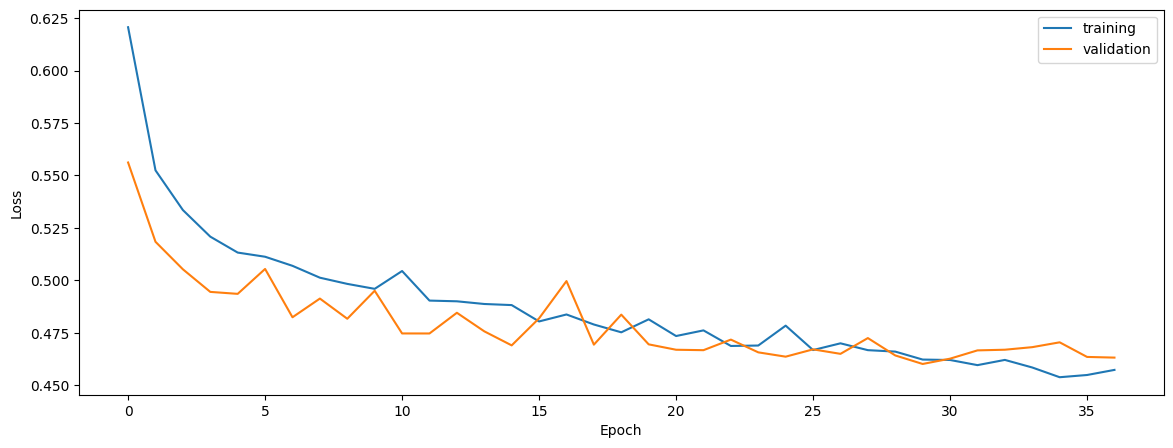

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6612807057570917
0.6574333046471601
0.6225950002181405


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6581742073848221
0.6516668500385081
0.6278188364601099


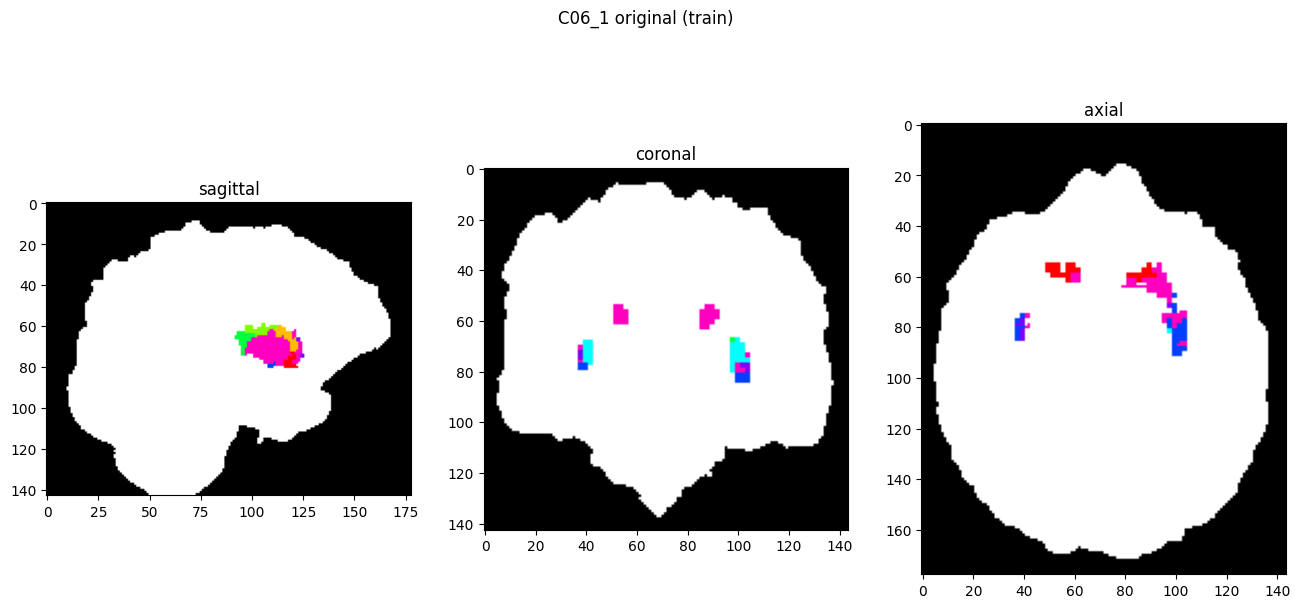

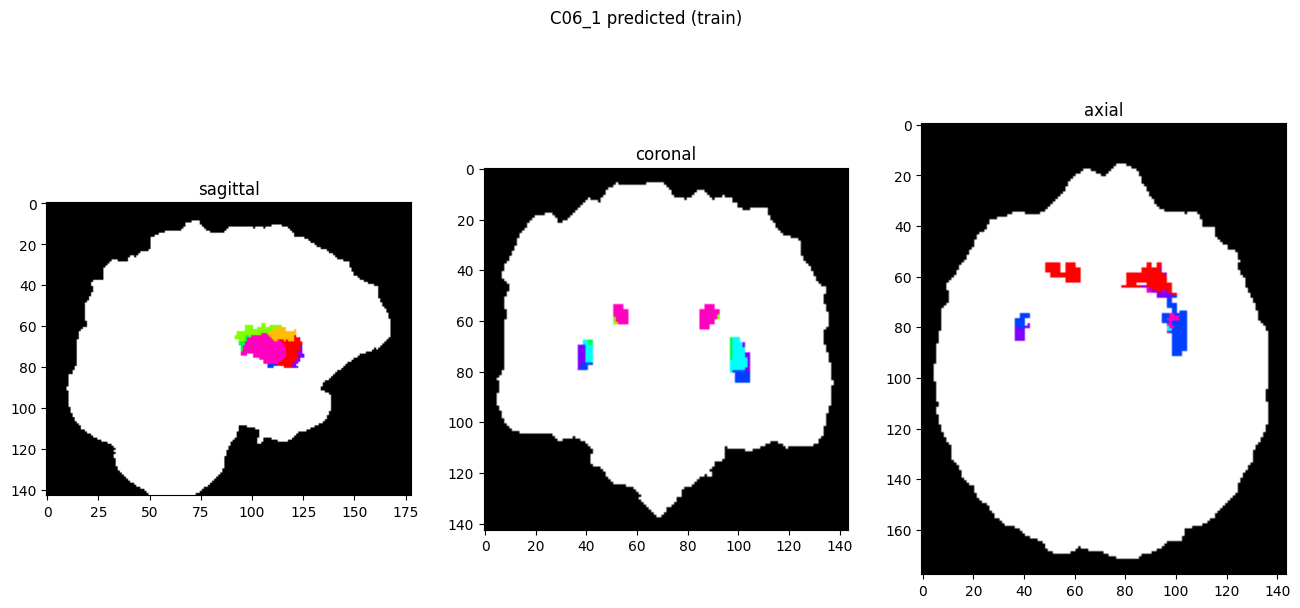

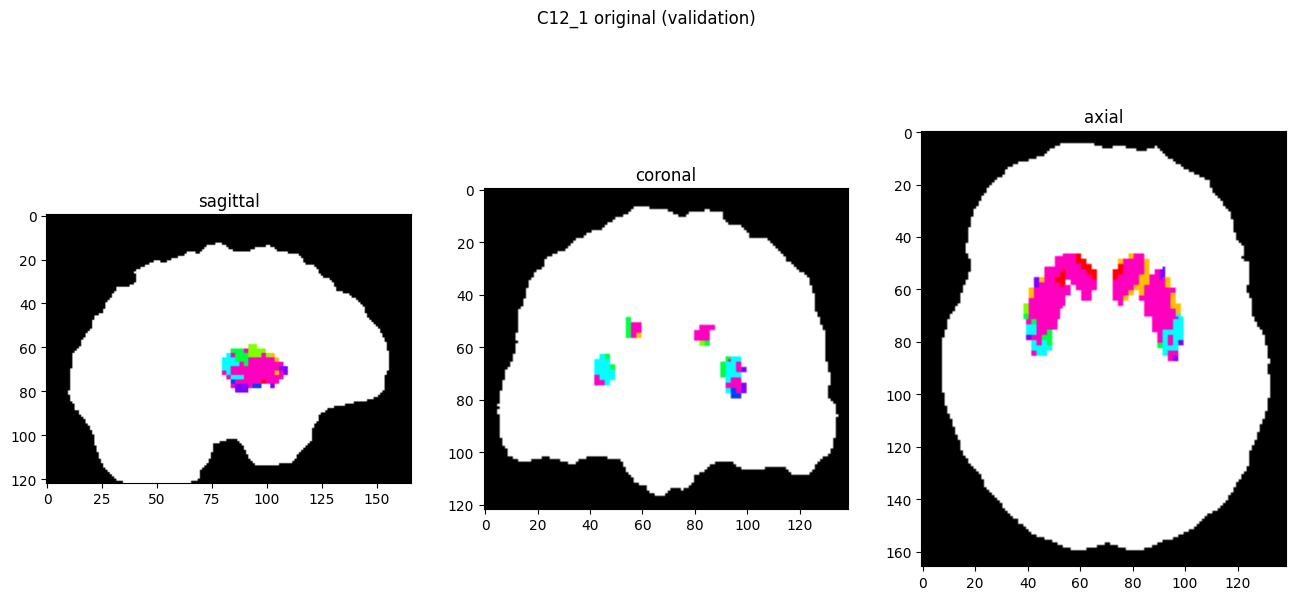

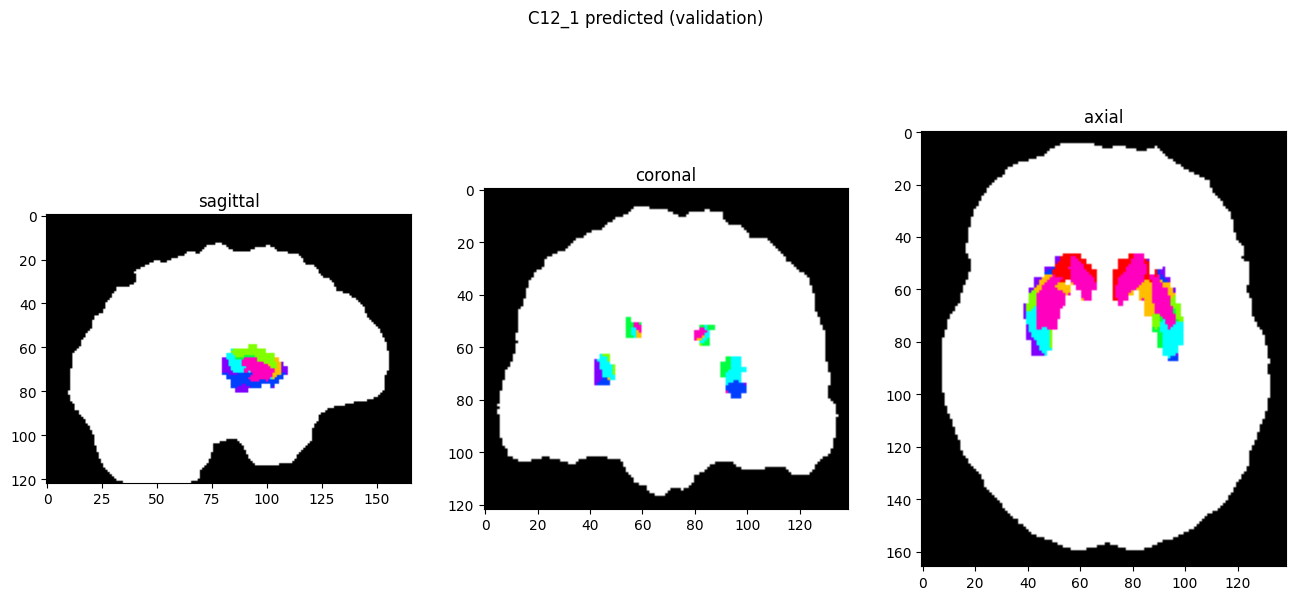

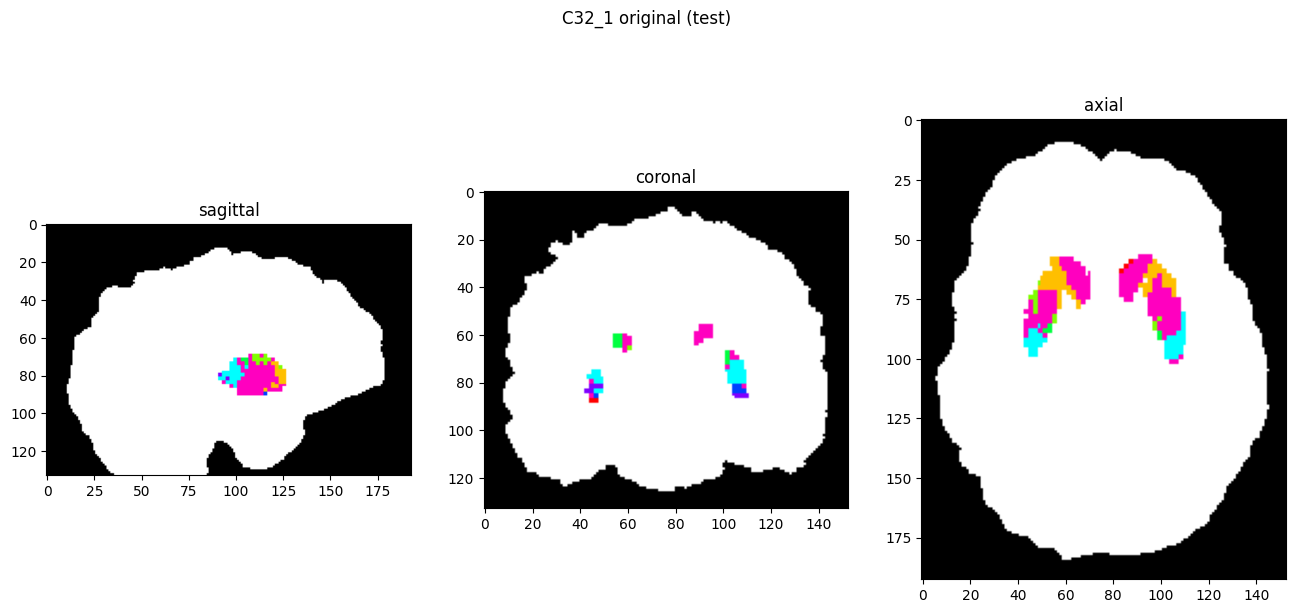

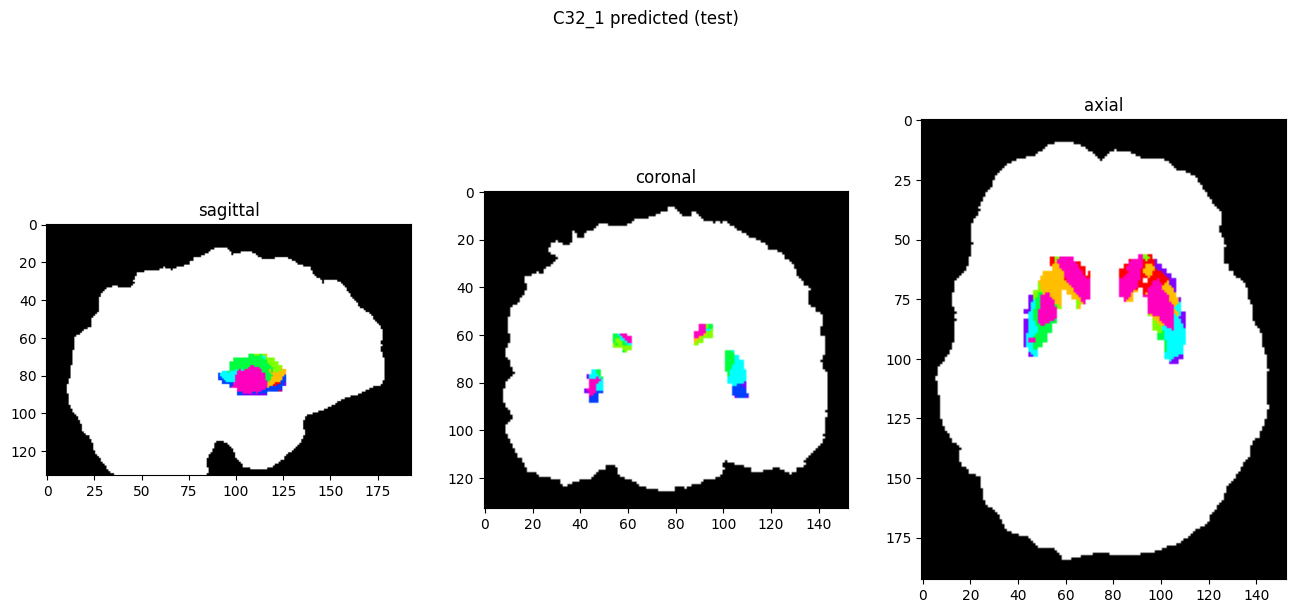

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)